# What makes a photo good? Metadata edition

Last time, I looked at a smaller dataset with bespoke features from looking at the photos.

This time, I'll use the metadata from my photo archives (about 30k photos) with coarser features. We'll be able to use more powerful techniques, but we'll be missing a lot of explanatory power.

I start by taking a few naive approaches:
- simple correlations  
- fit `LR`  
- fit `XGB`  

Then I try using some more sophisticated graph-based causal inference methods (regression-based, double ML, doubly-robust estimation) from `DoWhy` and `EconML`.  
Ultimately, results are pretty inconsistent, and it's hard to say what happened - but directionally, some evidence points to my preferring photos of film that I've shot and scanned. (Given a lower shots_taken/time, this would be expected; I haven't attempted to control for this, and it would be very hard to do so, since I'd need to have `session_start` and `session_end` for each photography session.)

#### Boilerplate

In [1]:
# Jan boilerplate, rev 2019/07/24

from datetime import date, datetime
import os
import sys
import pprint
import gc

import numpy as np
import pandas as pd

import scipy as sp
import scipy.stats

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import sklearn as skl

#import pymc3 as pm

import xgboost as xgb

# This notebook expects Python 3.
assert(sys.version_info >= (3, 4))

print(f'Python version: {sys.version}')
pd.show_versions()
print('Working directory: ', os.getcwd())
print(f'Current time {datetime.now()}')

# Display more rows, columns
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 80)
pd.set_option('display.width', 140)

# Auto reload extensions before executing, 
#   so we can edit references without restarting kernel.
#%load_ext autoreload
#%autoreload 2

# Print everything without requiring print statements.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# Wide window (fill up screen horizontally)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))


# # # Graph styling

# big graphs
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set_context('talk')
sns.set_palette('GnBu')
sns.set_style('whitegrid')
# fix palette
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (10.6, 6)
# fonts
plt.rcParams['font.sans-serif'] = ['Univers LT Std 55 Roman', 'Frutiger CE 55 Roman', 'SchulbuchNord Normal', 'Helvetica', 'sans-serif']
plt.rcParams['font.serif'] = ['Optima', 'serif']
plt.rcParams['font.monospace'] = ['Roboto Mono']
plt.rcParams['font.family'] = "sans-serif"
# big text
font = {'family' : 'sans-serif',
        'weight' : 'regular',
        'size'   : 16}
plt.rc('font', **font)
# slightly thinner linewidth, smaller markers
mpl.rcParams['lines.linewidth'] = 2.0
mpl.rcParams['lines.markersize'] = 6
# background
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
# plot colors
from cycler import cycler
hexes = ['#008fd5', '#d14e23', '#8ac42f', '#54904f', '#5cadab', '#540f91', '#ff1cb0', '#ffa01c']
colors = cycler('color', hexes)
plt.rcParams['axes.prop_cycle'] = colors 

# # #


# default percentiles
percentiles = [.05, .10, .25, .5, .75, .90, .95]

# pretty printer
pp = pprint.PrettyPrinter(indent=4)
p = lambda x: pp.pprint(x)

# # #   
# Convenience functions

def do_gc() -> None:
    """
    Prevent memory explosion from unclosed figures
    """
    plt.cla(), plt.clf(), plt.close('all'); import gc; gc.collect()
    return None


def auto_encode_categoricals(df: pd.DataFrame, thresh_uniq_vals:float=.01) -> pd.DataFrame:
    """
    Convert all object / string columns with (# uniq vals / # total vals) < threshold to category.
    Note: Rarely, a column will need to be 'object' (Python object) type 
      to be compatible with Pandas functions.
    df: pd.DataFrame, to downcast to categorical
    thresh_uniq_vals: float, proportion of unique values to require to downcast
    """
    cols = df.select_dtypes(include=['object']).columns.tolist()
    thresh_absolute = thresh_uniq_vals * len(df)
    cat_cols = [
        col for col in cols if (len(df[col].unique()) < thresh_absolute)
    ]
    print('Converting these columns to categorical:')
    p(cat_cols)
    # Have to use a for here due to pd limitation:
    for col in cat_cols:
        df[col] = df[col].copy(deep=True).astype('category')
    return df

def downcast_int(df: pd.DataFrame) -> pd.DataFrame:
    """
    Downcast numeric types in a DataFrame to save memory.
    Note: this will end up dropping duplicated columns, 
          but one would hope you haven't duplicated columns.
    Note 2: some Pandas operations may only exist for floats or higher-bit ints.
    
    df: pd.DataFrame, to downcast
    """
    full = df.copy()
    # We can run into issues if we have duplicated columns - drop them.
    full = df.loc[:,~df.columns.duplicated()]
    df = full.select_dtypes(include=[np.number])
    num_cols = df.columns
    non_num_cols = set(full.columns) - set(df.columns)
    for col in num_cols:
        not_null = not df[col].isnull().any()
        not_small = df[col].abs().mean() > 1.10  # avoid round small floats to 0
        not_fractional = np.isclose(df[col].values, df[col].round(0).values).all()
        downcast = (not_null and not_small and not_fractional)
        if downcast:
            print(f'Downcast column {col}')
            df.loc[:, col] = pd.to_numeric(df[col].copy(deep=True), downcast='integer')
        else:
            pass
        
    df = pd.concat([full[list(non_num_cols)], df], axis='columns')
    return df

do_gc;

Python version: 3.6.13 |Anaconda, Inc.| (default, Jun  4 2021, 14:25:59) 
[GCC 7.5.0]

INSTALLED VERSIONS
------------------
commit           : b5958ee1999e9aead1938c0bba2b674378807b3d
python           : 3.6.13.final.0
python-bits      : 64
OS               : Linux
OS-release       : 5.10.16.3-microsoft-standard-WSL2
Version          : #1 SMP Fri Apr 2 22:23:49 UTC 2021
machine          : x86_64
processor        : x86_64
byteorder        : little
LC_ALL           : None
LANG             : C.UTF-8
LOCALE           : en_US.UTF-8

pandas           : 1.1.5
numpy            : 1.17.0
pytz             : 2021.1
dateutil         : 2.8.2
pip              : 21.2.2
setuptools       : 52.0.0.post20210125
Cython           : 0.29.24
pytest           : None
hypothesis       : None
sphinx           : None
blosc            : None
feather          : None
xlsxwriter       : None
lxml.etree       : None
html5lib         : None
pymysql          : None
psycopg2         : None
jinja2           : 3.0.1
IPython

## Try using metadata instead of manual tags

Since this is automatic, sample will increase dramatically.
But we'll miss out on lots of important details.

I used the ListView plugin for Lightroom for this: https://www.photographers-toolbox.com/products/jbeardsworth/listview/  

In [2]:
ratings_md = pd.read_csv('../photos_dataset_through_2020_v2.csv')  # md = from METADATA

ratings_md.columns = [c.lower().replace(' ', '_') for c in ratings_md.columns]

# fix colnames
ratings_md = ratings_md.rename(columns={'size': 'size_mb', 'model': 'camera', 'date_time': 'taken_at'})  # shadows df.size 
                               
# munge
ratings_md.rating = ratings_md.rating.fillna(0)
ratings_md.taken_at = pd.to_datetime(ratings_md.taken_at)
ratings_md.camera = ratings_md.camera.str.lower()#.astype('category') 
ratings_md.focal_length = ratings_md.focal_length.str.replace(r'[^0-9.]', '', regex=True).astype('float')
ratings_md.iso = ratings_md.iso.str.replace('\D', '', regex=True).astype('float')
# probably care about log iso, since it grows exponentially
ratings_md['ln_iso'] = np.log(ratings_md.iso)
ratings_md[['width_px', '_', 'height_px']] = ratings_md.cropped.str.split(' ', expand=True)
ratings_md.width_px = ratings_md.width_px.astype('float')
ratings_md.height_px = ratings_md.height_px.astype('float')
ratings_md['resolution_mp'] = ratings_md.width_px * ratings_md.height_px / 1_000_000
ratings_md['rated_1_plus'] = ratings_md.rating.str.startswith('*').astype('float').fillna(0)
ratings_md['aspect_ratio'] = ratings_md.width_px / ratings_md.height_px

def try_float(x):
    try:
        return float(x)
    except:
        return np.nan

ratings_md.size_mb = ratings_md.size_mb.apply(lambda x: try_float(x)).astype('float')

ratings_md = ratings_md.drop(['_', 'unnamed:_10'], axis=1)  # columns created as side effect of width and height extraction

ratings_md.info()
ratings_md.sample(20,random_state=123)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28778 entries, 0 to 28777
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   file_name      28778 non-null  object        
 1   taken_at       26731 non-null  datetime64[ns]
 2   camera         28051 non-null  object        
 3   focal_length   25613 non-null  float64       
 4   cropped        28778 non-null  object        
 5   exposure       26440 non-null  object        
 6   size_mb        0 non-null      float64       
 7   rating         28778 non-null  object        
 8   flag           28778 non-null  int64         
 9   iso            26442 non-null  float64       
 10  ln_iso         26442 non-null  float64       
 11  width_px       28778 non-null  float64       
 12  height_px      28778 non-null  float64       
 13  resolution_mp  28778 non-null  float64       
 14  rated_1_plus   28778 non-null  float64       
 15  aspect_ratio   2877

,file_name,taken_at,camera,focal_length,cropped,exposure,size_mb,rating,flag,iso,ln_iso,width_px,height_px,resolution_mp,rated_1_plus,aspect_ratio
16208,_DSF4772-HDR.dng,2017-09-17 23:04:47,x-pro2,23.00,3973 x 5960,1/340 sec at ƒ / 5.6,NaN,0,1,200.0,5.298317,3973.0,5960.0,23.679080,0.0,0.666611
23560,IMG_20191022_160957.jpg,2019-10-22 16:09:57,pixel 3 xl,4.44,3024 x 4032,1/125 sec at ƒ / 1.8,NaN,0,0,1319.0,7.184629,3024.0,4032.0,12.192768,0.0,0.750000
371,IMG_4845.CR2,2010-06-05 10:14:24,canon eos digital rebel xti,70.00,3888 x 2592,1/2500 sec at ƒ / 2.8,NaN,0,0,100.0,4.605170,3888.0,2592.0,10.077696,0.0,1.500000
4715,_J2A2623.CR2,2012-12-03 02:16:57,canon eos 5d mark iii,85.00,5760 x 3840,1/125 sec at ƒ / 5.0,NaN,0,0,400.0,5.991465,5760.0,3840.0,22.118400,0.0,1.500000
28274,_DSF0797.RAF,2020-10-10 17:48:53,gfx 100,50.00,11648 x 8736,1/50 sec at ƒ / 8.0,NaN,0,0,500.0,6.214608,11648.0,8736.0,101.756928,0.0,1.333333
21883,LM103837.DNG,2019-05-04 15:14:24,leica m10,50.00,5976 x 3984,1/350 sec at ƒ / 5.6,NaN,0,0,200.0,5.298317,5976.0,3984.0,23.808384,0.0,1.500000
5218,_J2A3187.CR2,2013-02-09 15:16:58,canon eos 5d mark iii,47.00,5760 x 3840,1/30 sec at ƒ / 6.3,NaN,0,0,100.0,4.605170,5760.0,3840.0,22.118400,0.0,1.500000
23965,_R000383.DNG,2019-10-26 03:16:42,ricoh gr iii,18.30,6000 x 4000,1/40 sec at ƒ / 2.8,NaN,0,0,400.0,5.991465,6000.0,4000.0,24.000000,0.0,1.500000
190,IMG_4656.CR2,2010-06-01 12:17:44,canon eos digital rebel xti,105.00,3888 x 2592,1/50 sec at ƒ / 2.8,NaN,0,0,800.0,6.684612,3888.0,2592.0,10.077696,0.0,1.500000
1539,_MG_9454.CR2,2011-10-12 15:27:21,canon eos 5d,50.00,2912 x 4368,1/80 sec at ƒ / 1.8,NaN,0,1,100.0,4.605170,2912.0,4368.0,12.719616,0.0,0.666667


In [3]:
# add dt features

ratings_md['month'] = ratings_md['taken_at'].dt.month
ratings_md['year'] = ratings_md['taken_at'].dt.year

seasons = [1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1]
month_to_season = dict(zip(range(1,13), seasons))
ratings_md['ord_season'] = ratings_md['taken_at'].dt.month.map(month_to_season) 

ratings_md['date_ord'] = pd.to_timedelta(ratings_md.taken_at - ratings_md.taken_at.min()) / pd.to_timedelta('1d')
print('min date =', ratings_md.taken_at.min() )
print('max date =', ratings_md.taken_at.max() )

# fix camera phone FL
ratings_md.loc[ratings_md.camera.isin(['pixel 3 xl', 'sm-g955u']), 'focal_length'] = 28

ratings_md.camera.value_counts()

min date = 2010-03-09 11:25:38
max date = 2020-12-26 13:28:16


canon eos 5d mark iii          4920
ilce-7rm2                      4737
leica m10                      3376
gfx 50s                        3219
finepix x100                   2280
canon eos 5d                   2111
gfx 100                        1810
ez controller                  1214
pixel 3 xl                     1162
canon eos digital rebel xti     980
ricoh gr iii                    776
x-t4                            502
sm-g955u                        233
gr                              162
perfectionv800                  155
qss-32_33                       151
x-pro2                           95
perfection v600                  58
canon eos-1d mark ii             44
canon eos digital rebel xsi      34
iphone                           15
canon eos 5d mark ii             11
leica sl                          5
iphone 4                          1
Name: camera, dtype: int64

In [6]:
# exclude very rare cameras that I barely used (e.g. borrowed)

CAMERAS_INCLUDE = [
    'canon eos 5d mark iii',       
    'ilce-7rm2',            
    'leica m10',    
    'gfx 50s' ,
    'finepix x100' ,
    'canon eos 5d',
    'gfx 100',                        
    'ez controller' ,
    'pixel 3 xl' 
    'canon eos digital rebel xti' ,
    'ricoh gr iii',
    'x-t4'   ,
    'sm-g955u'  ,
    'gr'   ,
    'perfectionv800',
    'qss-32_33',
]

ratings_md = ratings_md.loc[ratings_md.camera.isin(CAMERAS_INCLUDE)]

In [7]:
CAMERA_ALIASES = {
    'ilce-7rm2': 'a7r_ii',
    'ez controller': 'noritsu_scanner',
    'qss-32_33': 'noritsu_scanner',
    'sm-g955u': 'samsung_s7_edge',  # s7 edge or s8+, not sure which
    'gr': 'ricoh gr',
}

ratings_md.camera = ratings_md.camera.replace(to_replace=CAMERA_ALIASES)

ratings_md['equiv_fl'] = ratings_md.focal_length.copy()

MFD_CAMERAS = ['gfx 50s', 'gfx 100']  # 0.80x crop factor
ratings_md.loc[ratings_md.camera.isin(MFD_CAMERAS), 'equiv_fl'] = 0.80 * ratings_md.equiv_fl

APSC_CAMERAS = [
    'finepix x100',
    'ricoh gr iii',
    'x-t4',
    'canon eos digital rebel xsi',
]

ratings_md.loc[ratings_md.camera.isin(APSC_CAMERAS), 'equiv_fl'] = 1.50 * ratings_md.equiv_fl  # actually 1.6x for canon, but close enough


In [8]:
# also tag film

fil_scanner = (ratings_md.camera.isin(['noritsu_scanner', 'perfectionv800', 'perfection v600', ]))
# not perfect b/c I do very occasionally shoot macro/product
fil_sony_macro = ((ratings_md.camera == 'a7r_ii') & (ratings_md.focal_length == 90.0))
fil_gf_macro = (
    (ratings_md.camera.isin(['gfx 50s', 'gfx 100'])) & (ratings_md.focal_length == 120)
)  # w/ extension shows up as 425mm, 444mm

ratings_md['is_film'] = (fil_scanner | fil_sony_macro | fil_gf_macro)

ratings_md.loc[(fil_sony_macro | fil_gf_macro), 'equiv_fl'] = np.nan  # actual focal length is taking lens, not scanning lens ;)

# also clip FL at 200mm, some weird data issues
ratings_md.equiv_fl = ratings_md.equiv_fl.clip(upper=200)

ratings_md.sample(10, random_state=2001)


,file_name,taken_at,camera,focal_length,cropped,exposure,size_mb,rating,flag,iso,ln_iso,width_px,height_px,resolution_mp,rated_1_plus,aspect_ratio,month,year,ord_season,date_ord,equiv_fl,is_film
21213,LM103371-HDR.dng,2019-01-12 15:36:08,leica m10,50.0,3956 x 5935,1/4000 sec at ƒ / 4.8,NaN,0,1,200.0,5.298317,3956.0,5935.0,23.478860,0.0,0.666554,1.0,2019.0,1.0,3231.173958,50.00,False
12204,_DSC1747.ARW,2016-08-15 12:16:39,a7r_ii,28.0,7952 x 5304,1/60 sec at ƒ / 5.6,NaN,0,0,100.0,4.605170,7952.0,5304.0,42.177408,0.0,1.499246,8.0,2016.0,3.0,2351.035428,28.00,False
19013,_DSF6696.RAF,2018-06-02 15:27:45,gfx 50s,64.0,8256 x 6192,1/160 sec at ƒ / 10,NaN,0,0,100.0,4.605170,8256.0,6192.0,51.121152,0.0,1.333333,6.0,2018.0,3.0,3007.168137,51.20,False
23952,LM104392.DNG,2019-10-26 03:04:18,leica m10,50.0,5976 x 3984,1/180 sec at ƒ / 2.4,NaN,0,0,200.0,5.298317,5976.0,3984.0,23.808384,0.0,1.500000,10.0,2019.0,4.0,3517.651852,50.00,False
6358,DSCF1518.RAF,2013-07-27 23:13:39,finepix x100,23.0,2848 x 4288,1/60 sec at ƒ / 2.8,NaN,0,0,1600.0,7.377759,2848.0,4288.0,12.212224,0.0,0.664179,7.0,2013.0,3.0,1236.491678,34.50,False
24361,LM104661.DNG,2019-10-31 06:49:13,leica m10,50.0,5976 x 3984,1/1000 sec at ƒ / 4.0,NaN,0,0,250.0,5.521461,5976.0,3984.0,23.808384,0.0,1.500000,10.0,2019.0,4.0,3522.808044,50.00,False
18090,_DSF6232.RAF,2018-03-04 12:42:51,gfx 50s,120.0,8256 x 6192,1/125 sec at ƒ / 8.0,NaN,0,0,400.0,5.991465,8256.0,6192.0,51.121152,0.0,1.333333,3.0,2018.0,2.0,2917.053623,NaN,True
17180,_DSF5443.RAF,2017-11-08 15:55:03,gfx 50s,41.1,8256 x 6192,1/160 sec at ƒ / 9.0,NaN,0,0,400.0,5.991465,8256.0,6192.0,51.121152,0.0,1.333333,11.0,2017.0,4.0,2801.187095,32.88,False
18153,_DSF6295.RAF,2018-03-04 13:35:12,gfx 50s,63.0,8256 x 6192,1/160 sec at ƒ / 8.0,NaN,0,0,250.0,5.521461,8256.0,6192.0,51.121152,0.0,1.333333,3.0,2018.0,2.0,2917.089977,50.40,False
21064,LM103279.DNG,2018-11-24 13:58:24,leica m10,50.0,5976 x 3984,1/6 sec at ƒ / 2.4,NaN,0,0,1600.0,7.377759,5976.0,3984.0,23.808384,0.0,1.500000,11.0,2018.0,4.0,3182.106088,50.00,False


In [9]:
def try_get_list_idx(lst, idx):
    try:
        return lst[idx]
    except TypeError:
        return np.nan

#ratings_md.sample(10, random_state=321).exposure.str.split(' ').apply(lambda x: try_get_list_idx(x, -1))

ratings_md['shutter'] = ratings_md.exposure.str.split(' ').apply(lambda x: try_get_list_idx(x, 0))
ratings_md['aperture'] = ratings_md.exposure.str.split(' ').apply(lambda x: try_get_list_idx(x, -1)).apply(try_float)

In [10]:
def frac_str_to_float(x):
    try: 
        parts = x.split('/')
        if len(parts) == 2:
            return try_float(parts[0]) / try_float(parts[-1])
        else:
            raise(AttributeError())
    except AttributeError:  # already float
        return x
    
    return np.nan

ratings_md['shutter'] = ratings_md['shutter'].apply(frac_str_to_float).astype('float')

In [11]:
# "edge resolution" just the resolution of a square photo's edge. in other words, perceived resolution ~ edge length, not megapixels
# (have to 2x edge length to double perceived resolution, meaning 4x megapixels)
ratings_md['edge_resolution_px'] = np.sqrt(ratings_md.resolution_mp * 1_000_000)

ratings_md['is_vertical'] = ratings_md.aspect_ratio < 1

# transform shutter to normal-ish
ratings_md['ln_shutter'] = np.log(ratings_md['shutter'])

_TODO: add minutes to sunset feature_ 

presumably, would need to find a csv of this somewhere + join to it. (last time I used an API, which would be very slow/inefficient without a batch mode.)

### Basic 1-d EDA

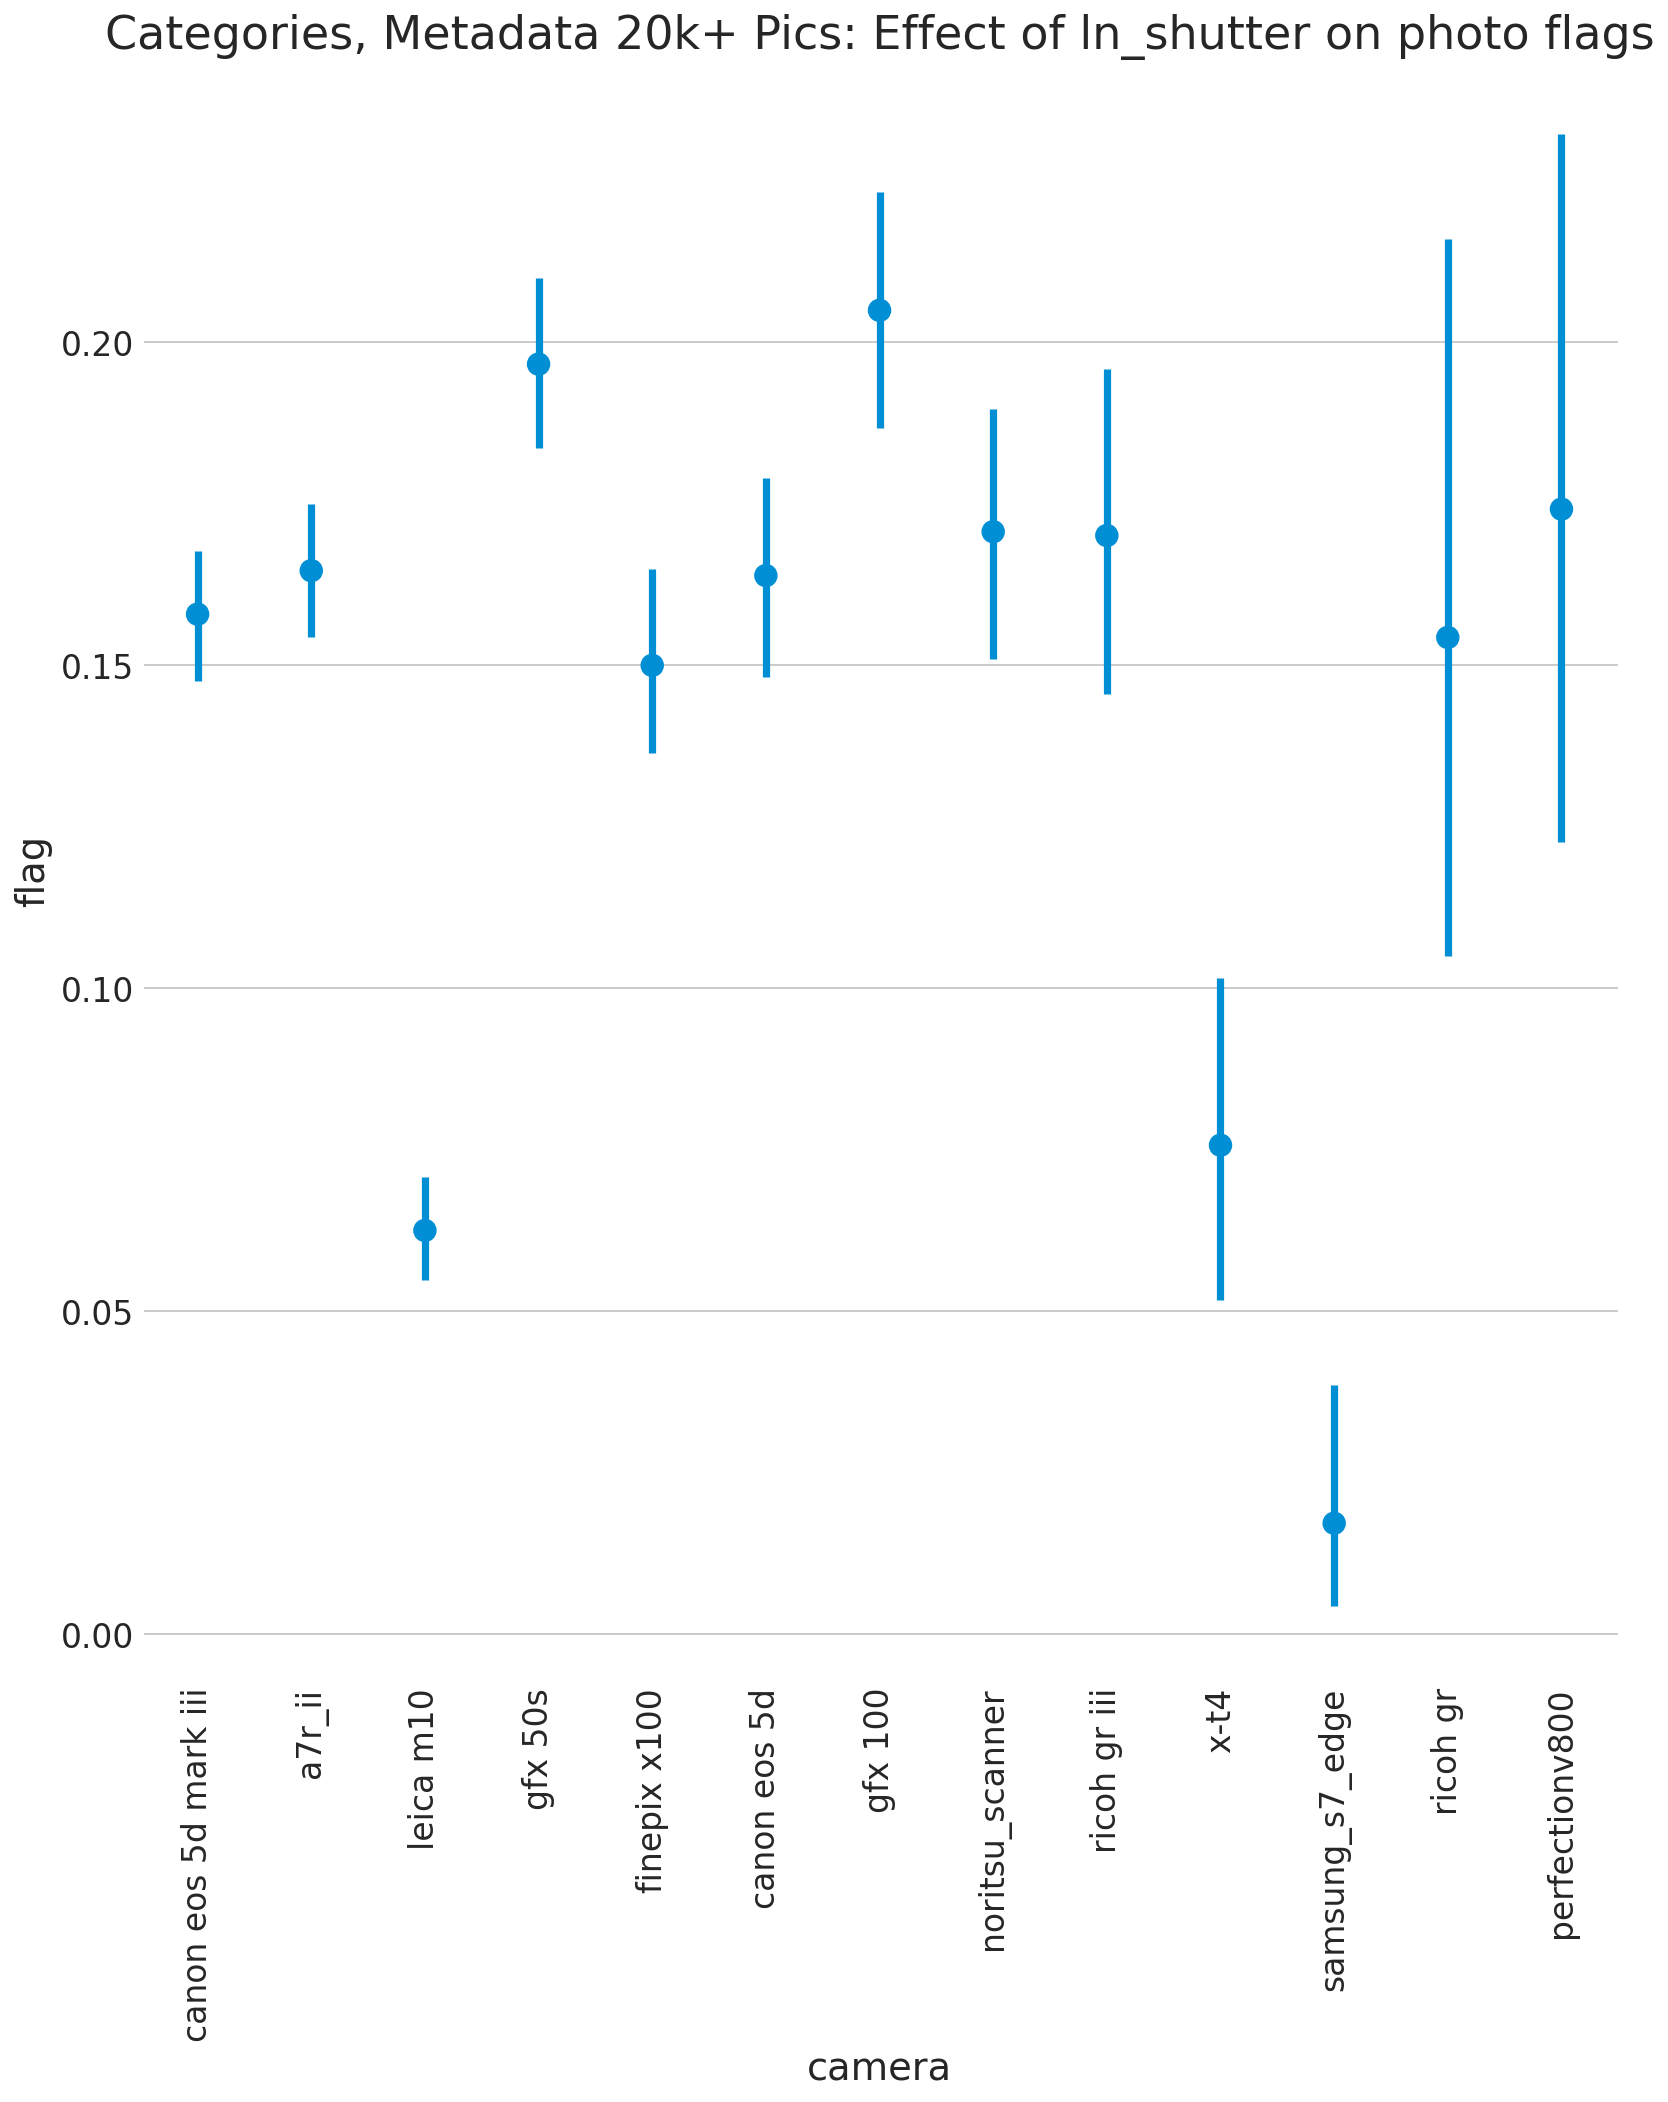

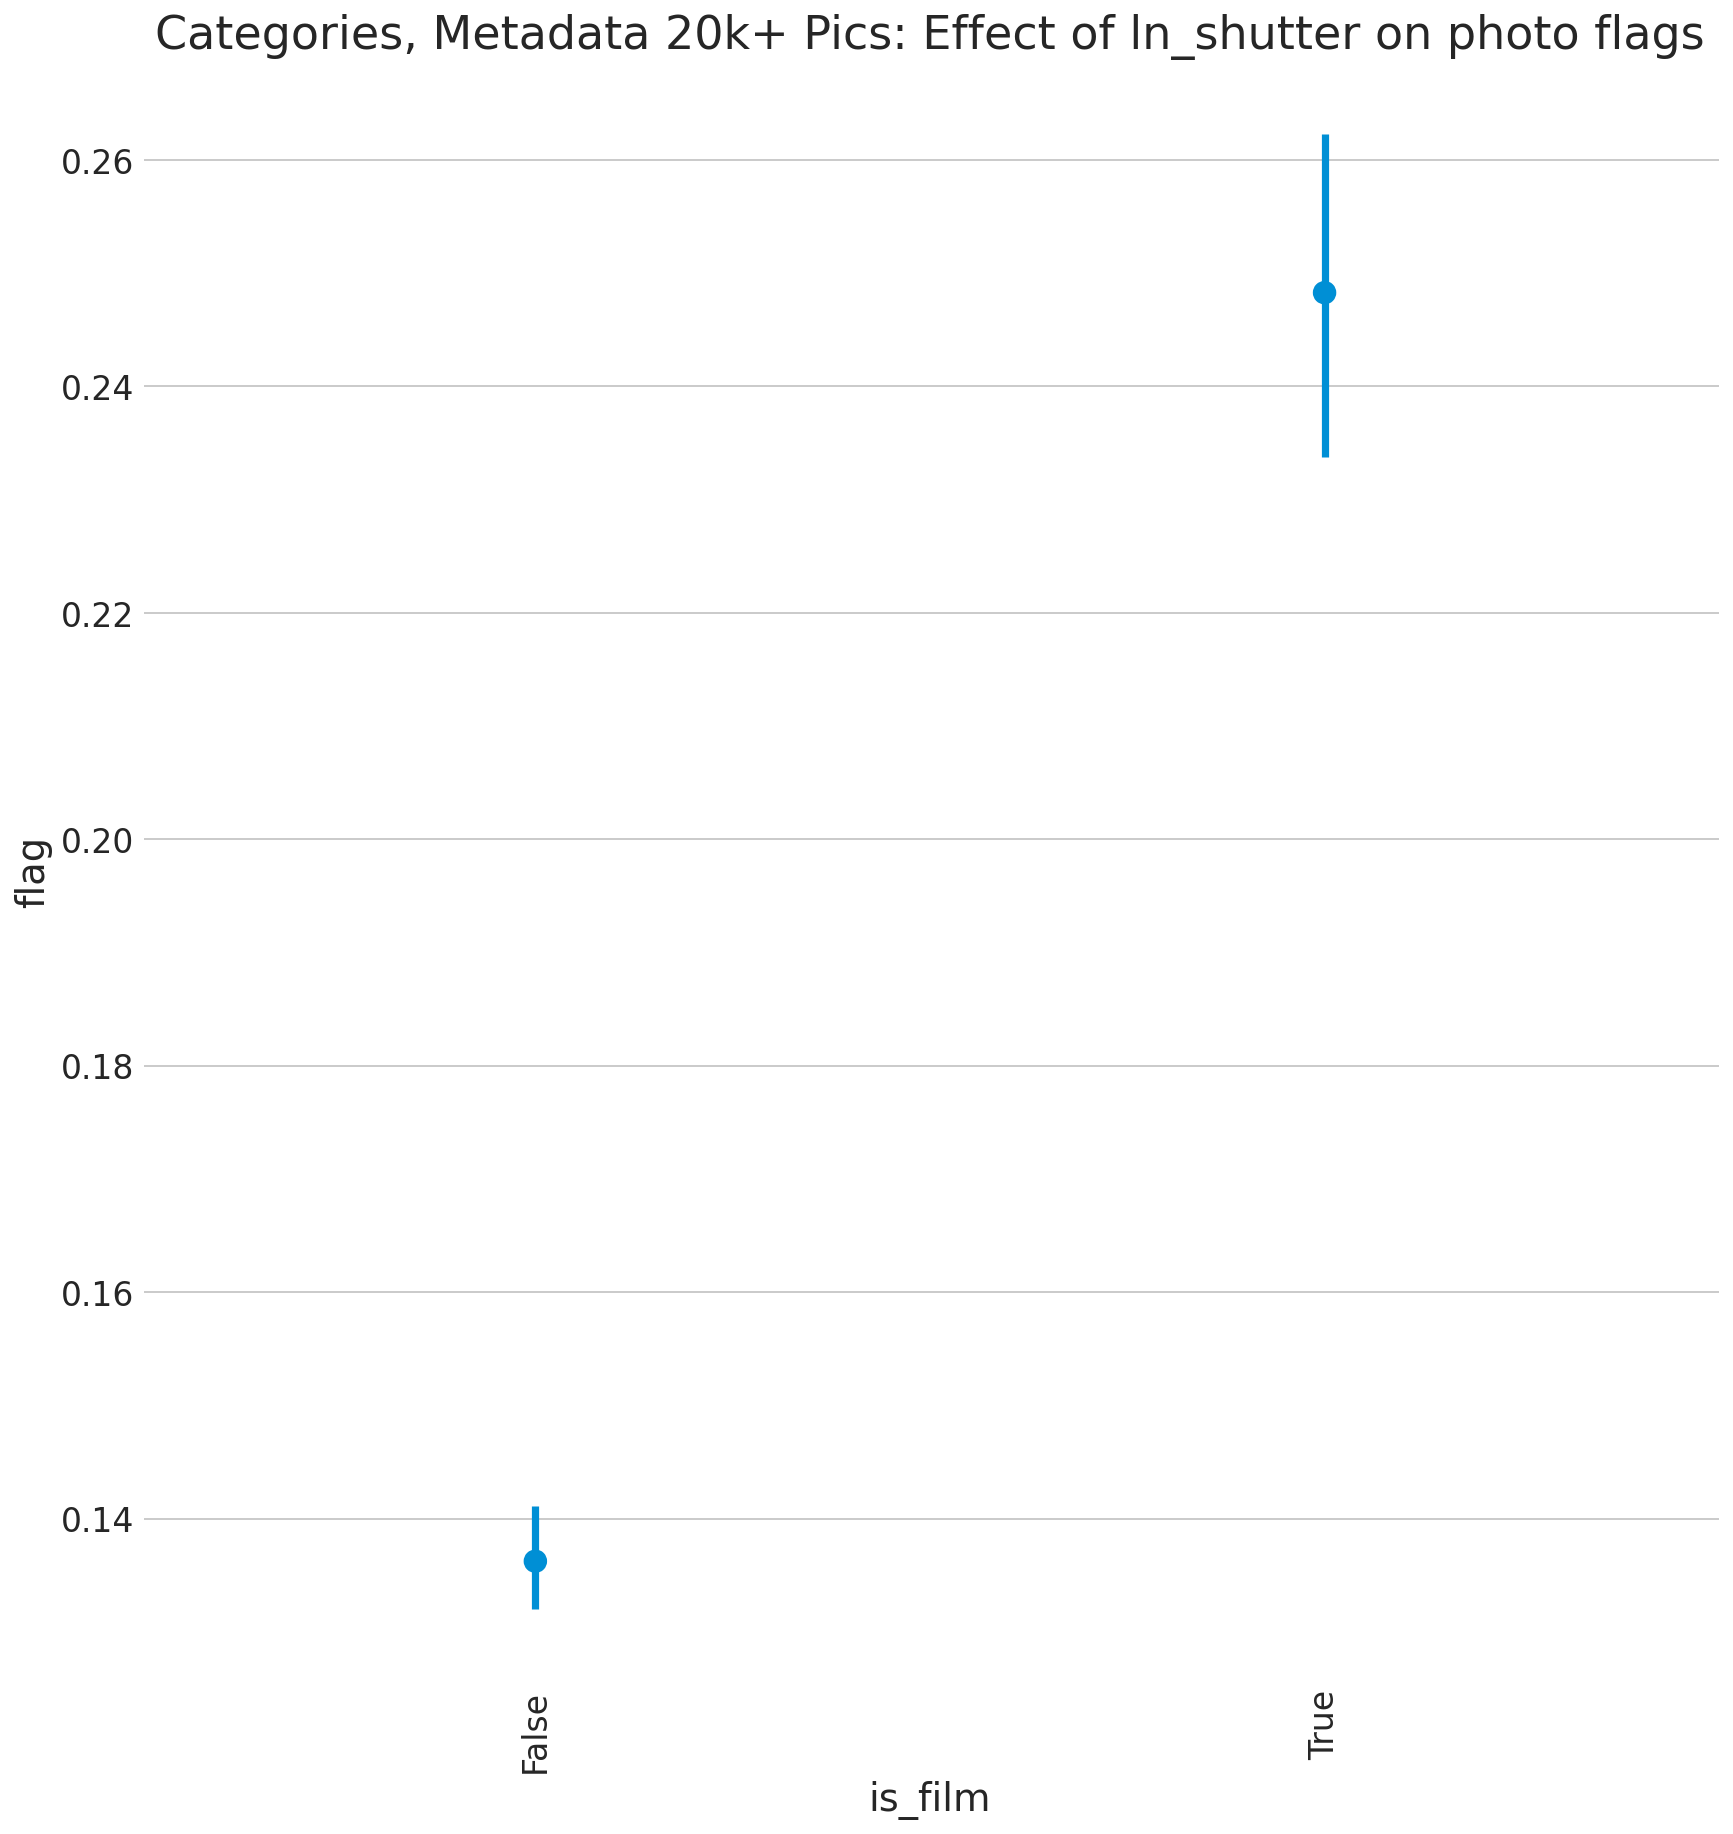

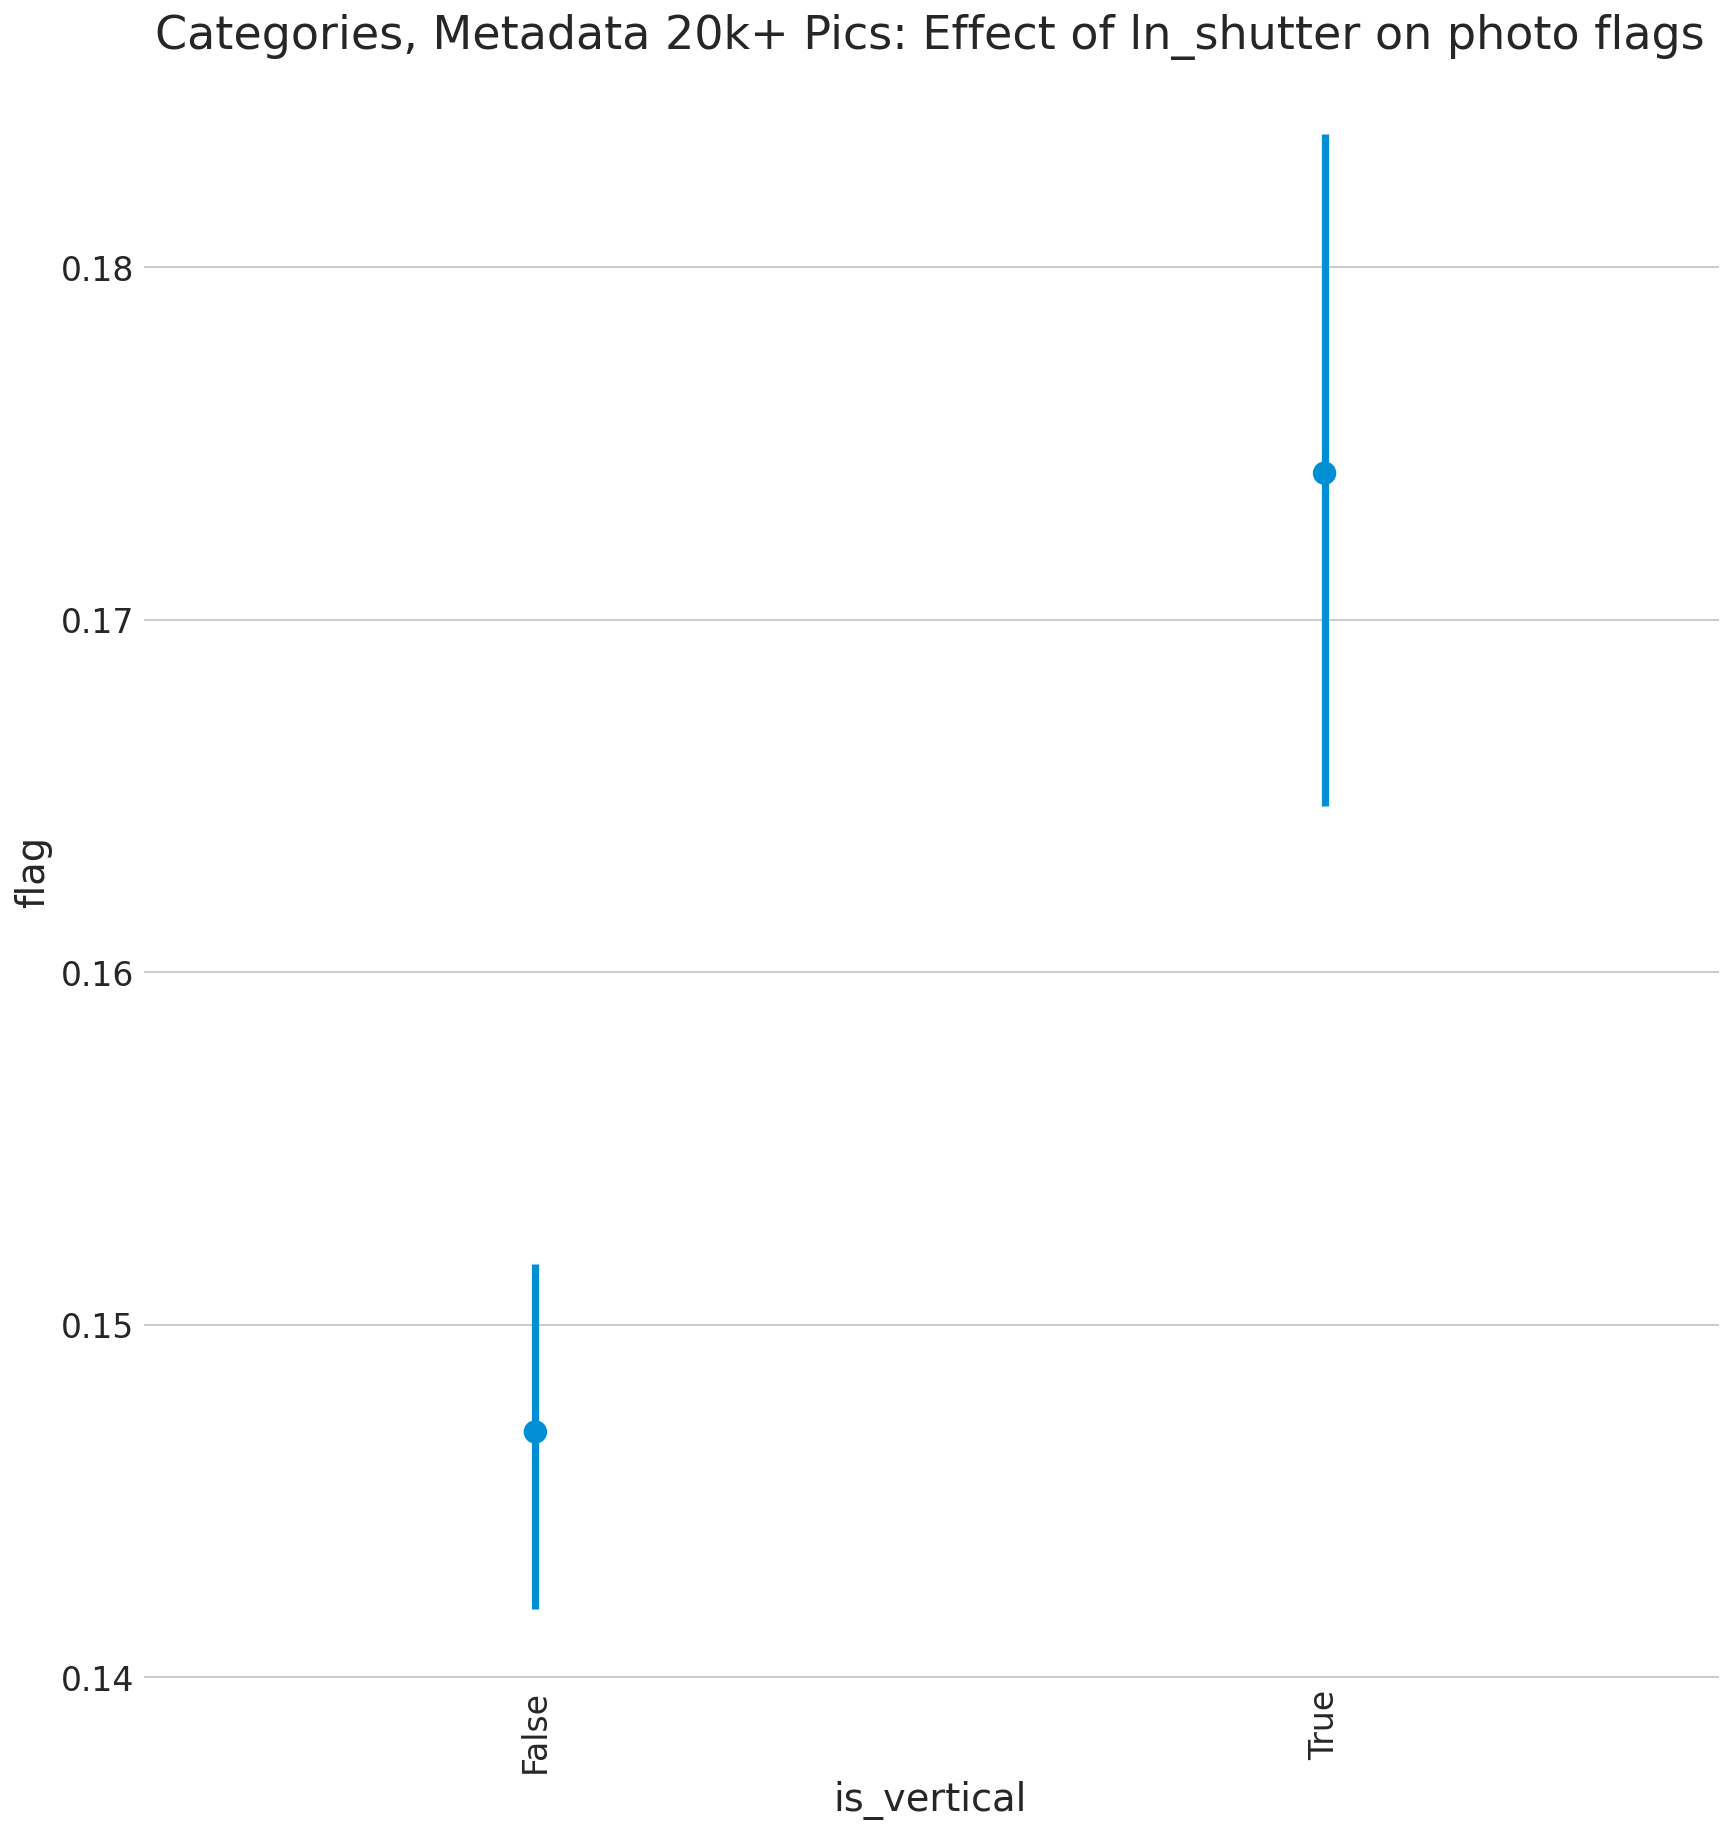

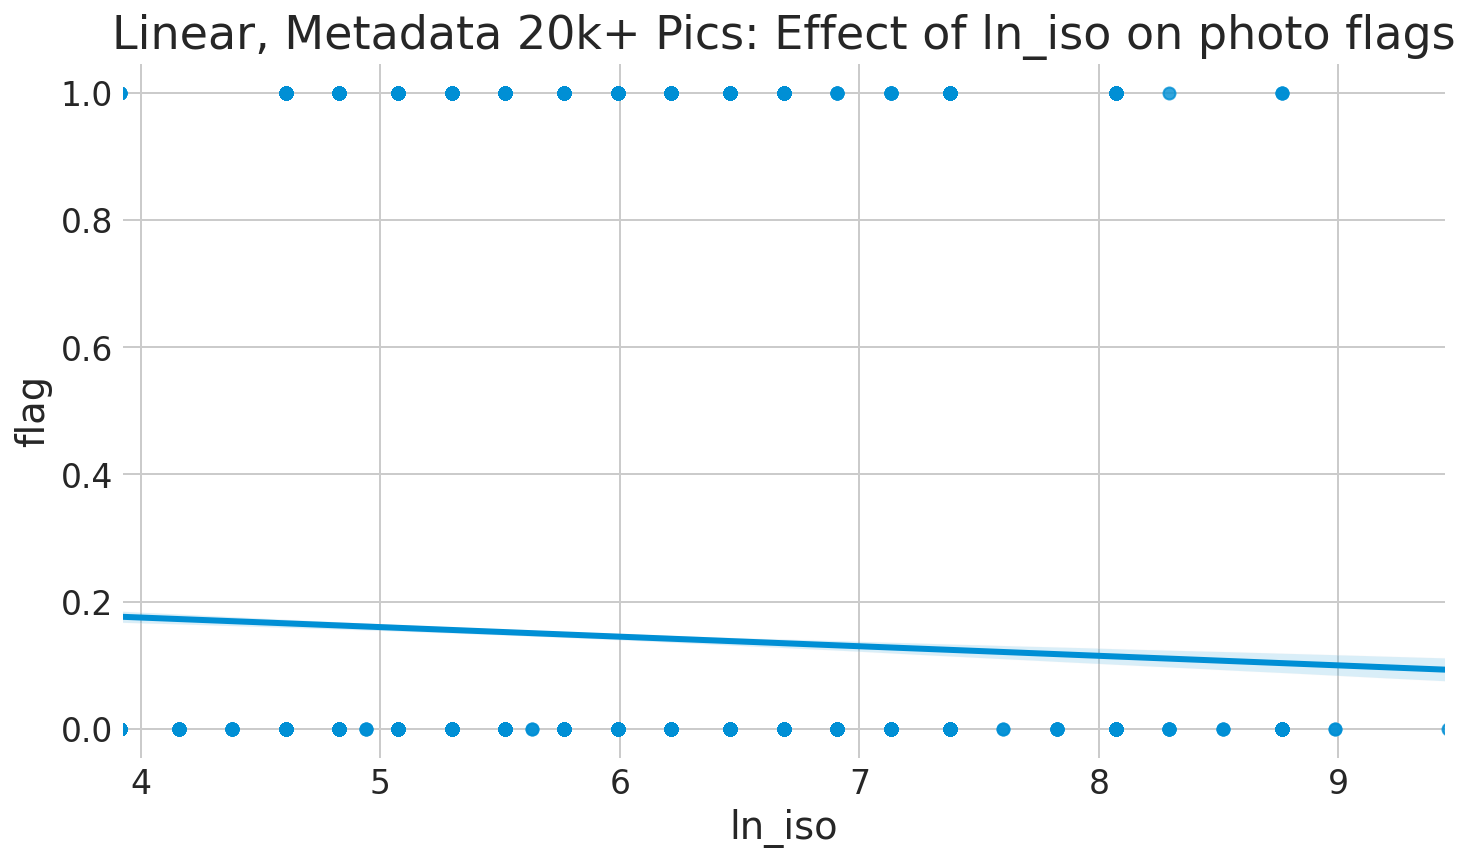

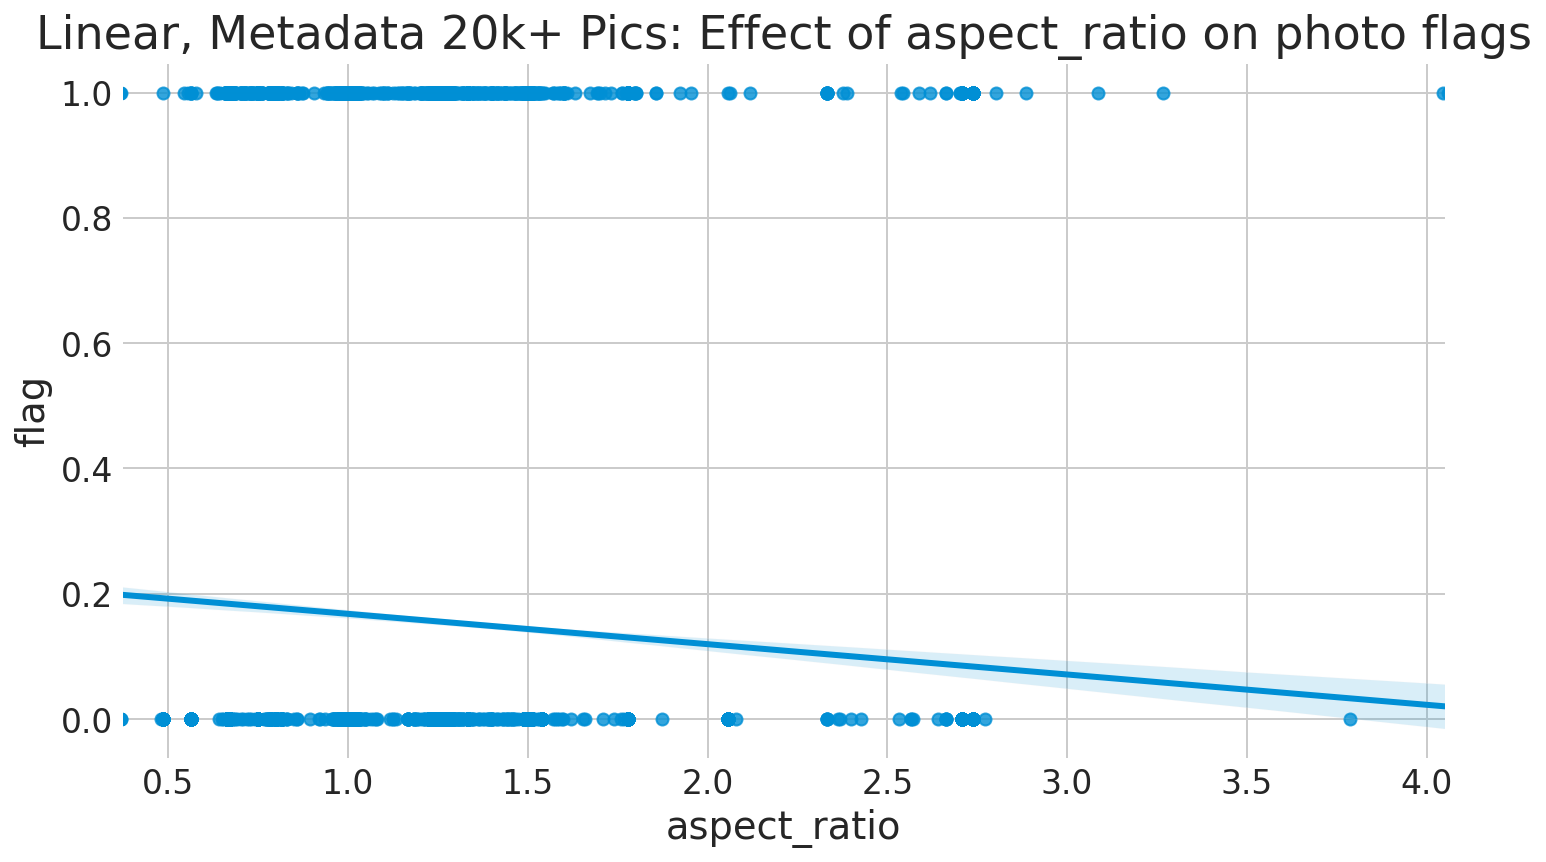

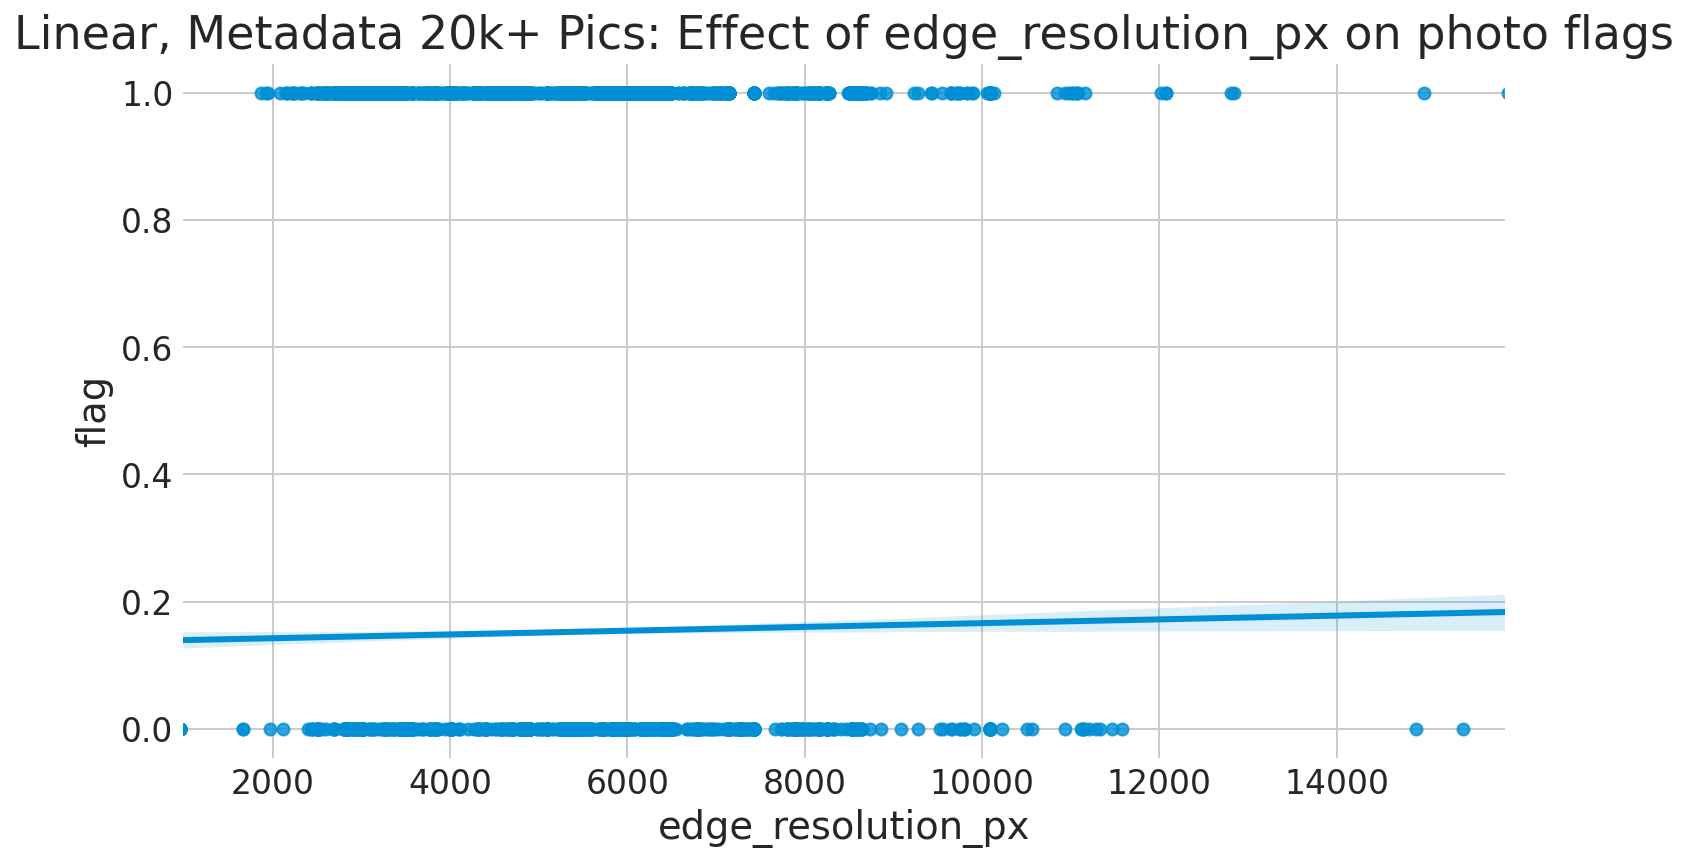

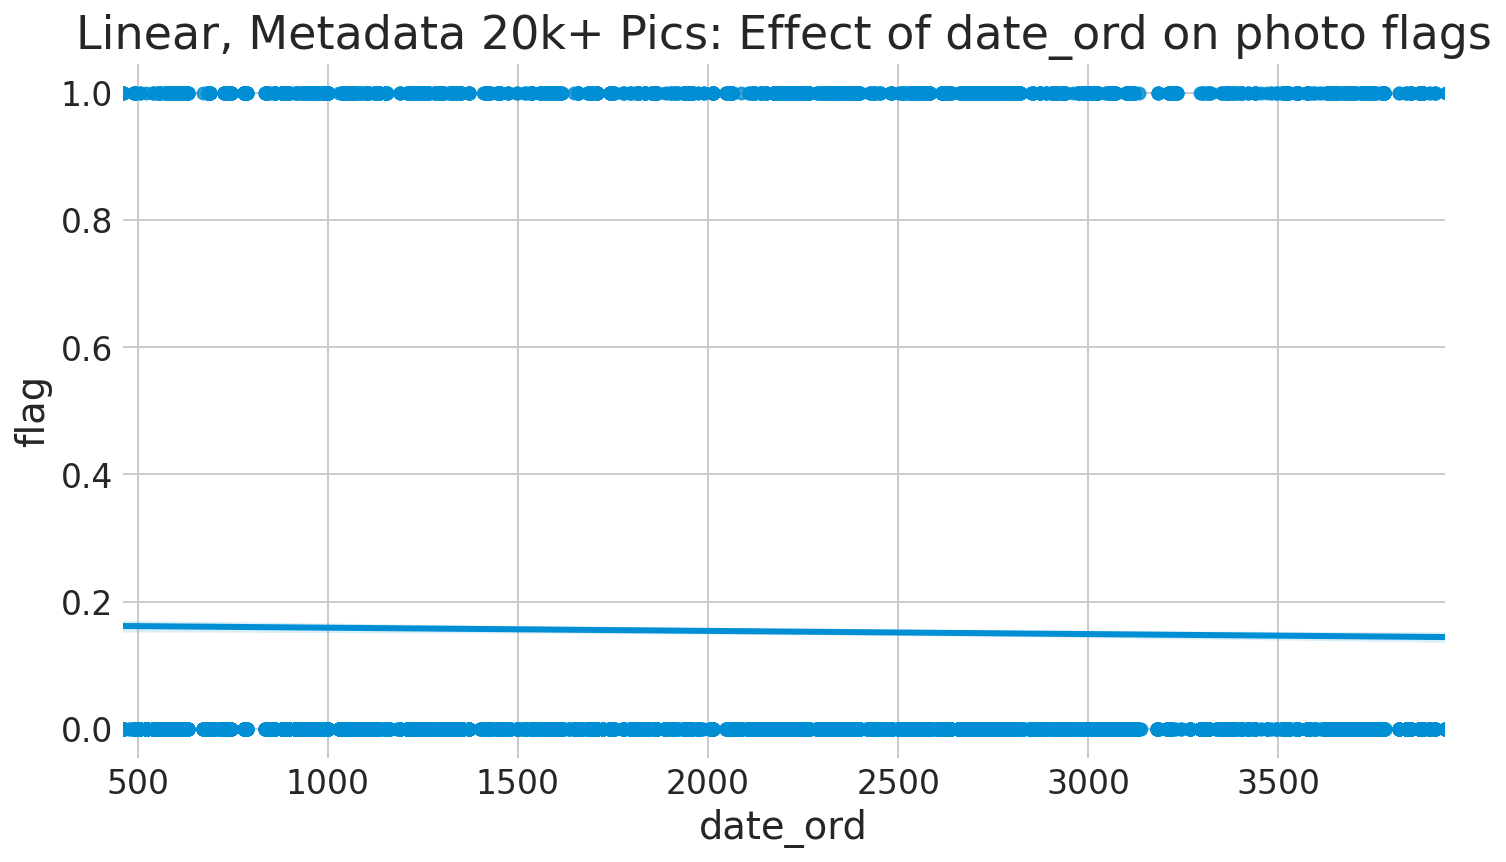

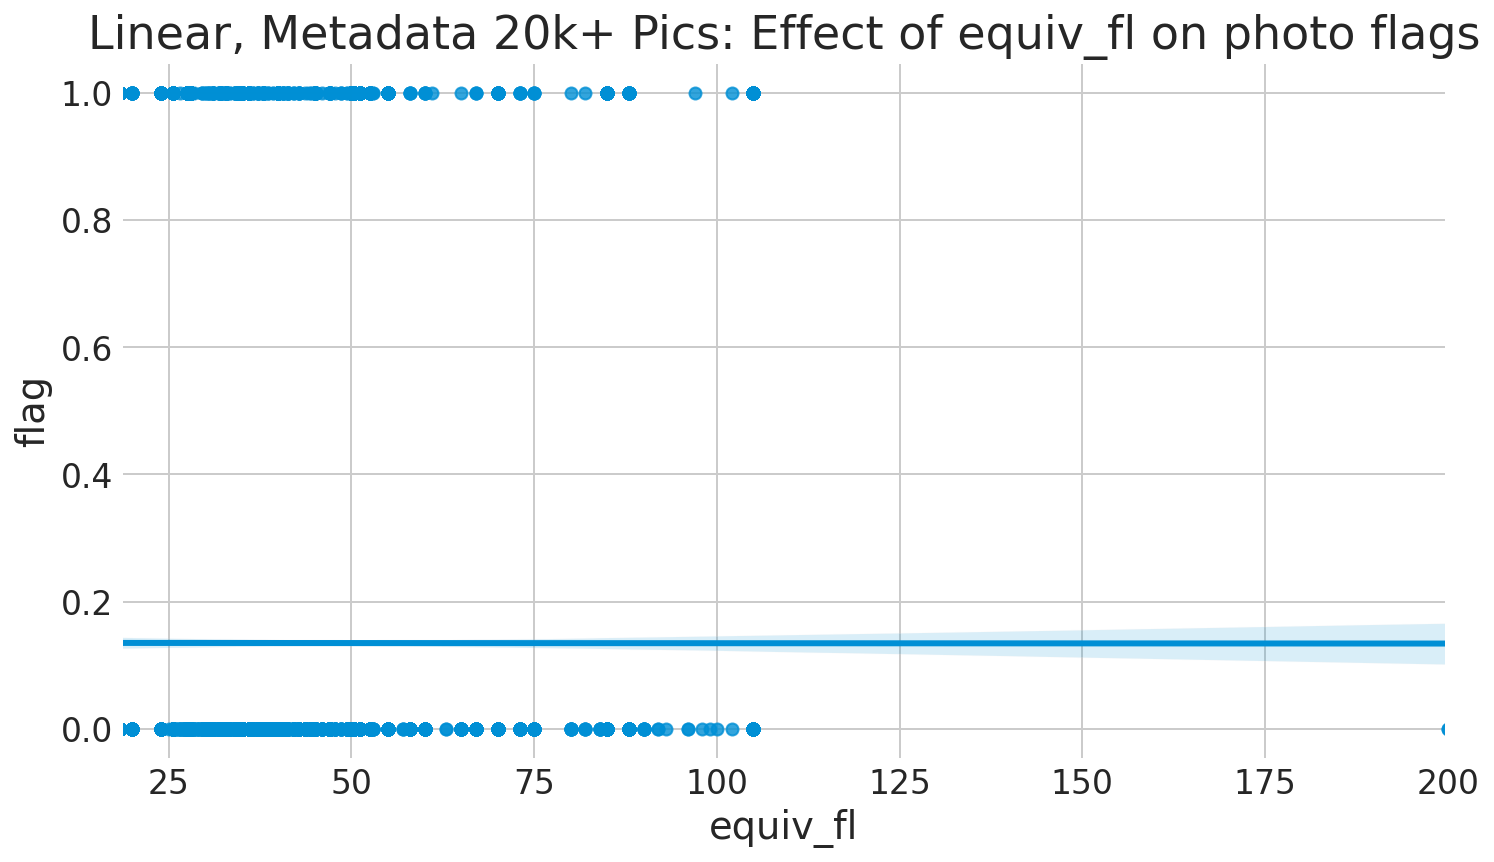

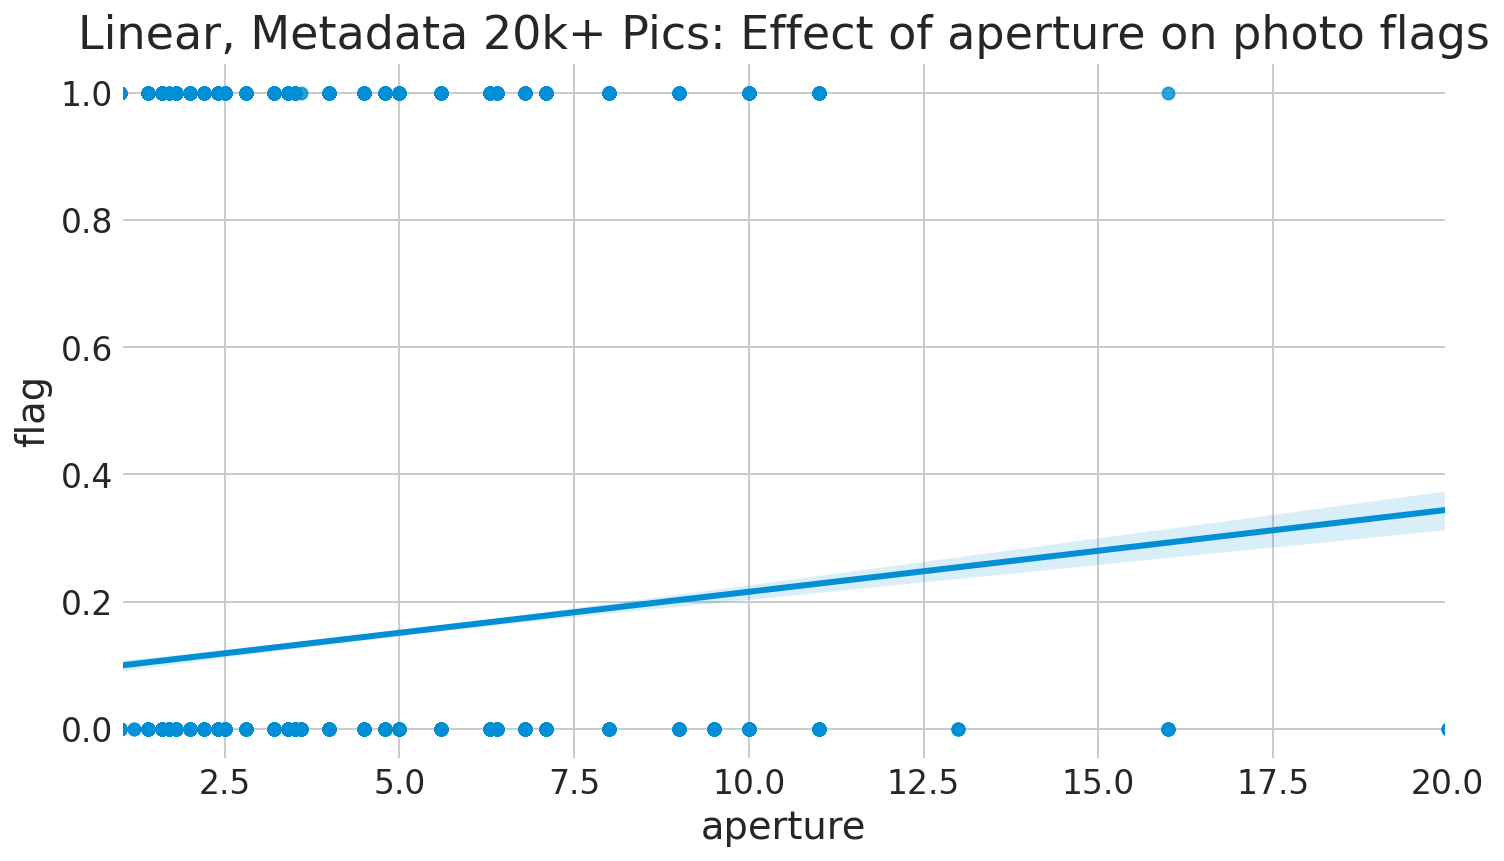

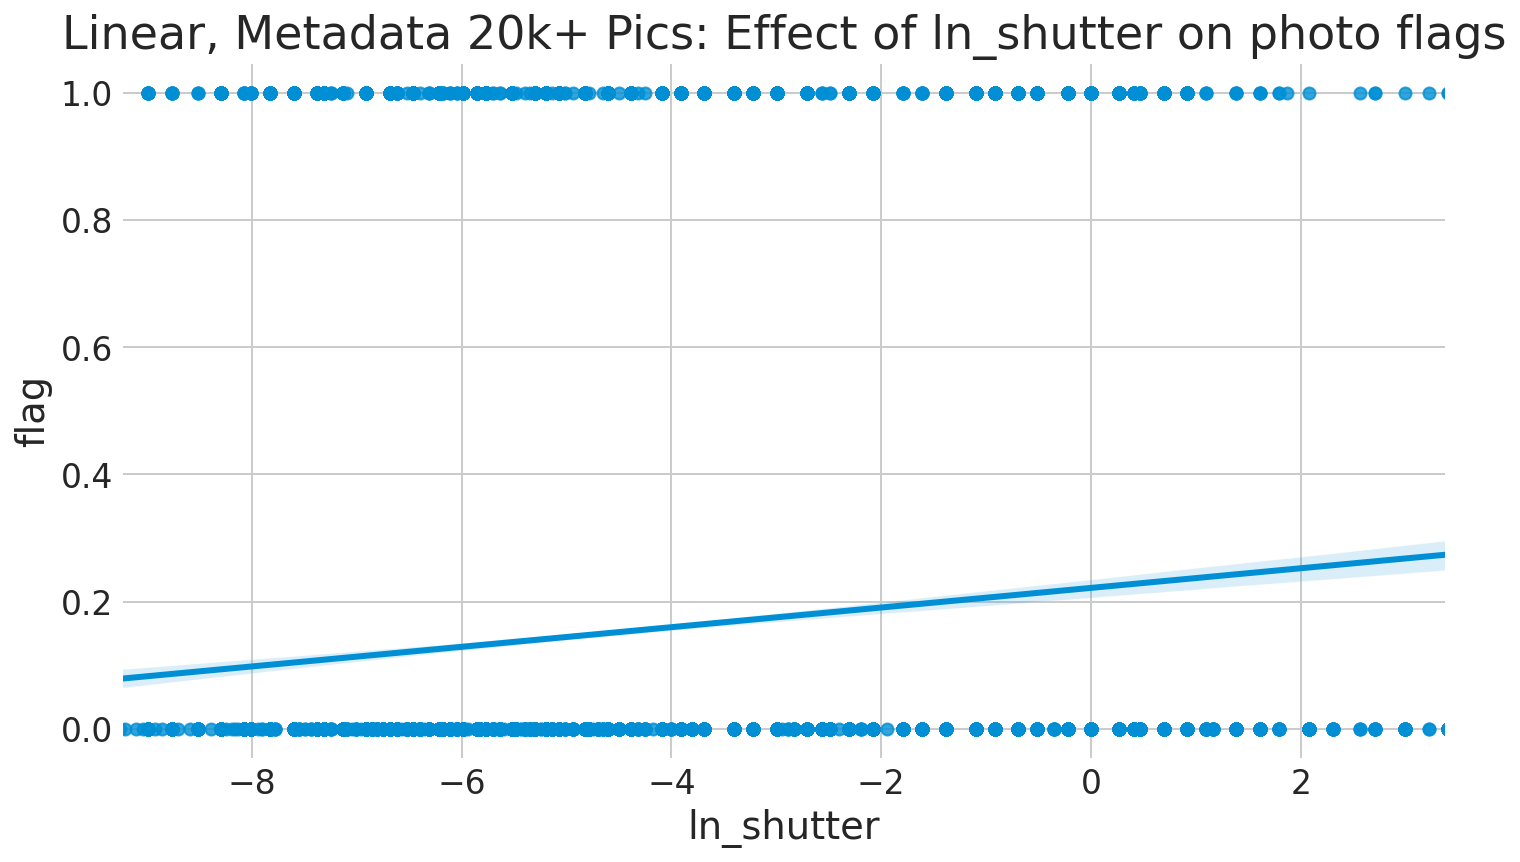

In [115]:
categorical_vars = [
    'camera',
    'is_film',
    'is_vertical',
]

OUTCOME = 'flag'

for factor in categorical_vars:
    freqs = ratings_md[factor].value_counts()
    # Filter on level of var occurred 3+ times; sort by freq
    freqs = freqs.loc[freqs >= 3]
    levels_to_eval = freqs.index
    
    _ = sns.catplot(
        x=factor,
        y=OUTCOME,
        data=ratings_md,
        order=levels_to_eval,
        kind='point',
        join=False,
        height=12,
    )
    _ = plt.title(f'Categories, Metadata 20k+ Pics: Effect of {var} on photo flags')
    _ = plt.xticks(rotation=90)
    plt.show()


cts_vars = [
    'ln_iso',
    'aspect_ratio',
    'edge_resolution_px',
    'date_ord',
    'equiv_fl',
    'aperture',
    'ln_shutter',
]

for var in cts_vars:
    _ = sns.regplot(
        x=var,
        y=OUTCOME,
        data=ratings_md,
        #size=12,
        #alpha=.05,
    )
    _ = plt.title(f"Linear, Metadata 20k+ Pics: Effect of {var} on photo flags")
    _ = plt.show()
    
    # lowess doesn't work well for binary outcome
#     sns.regplot(
#         x=var,
#         y=OUTCOME,
#         data=ratings_md,
#         lowess=True
#     )
#     plt.title(f"Lowess, Metadata 20k+ Pics: Effect of {var} on photo flags")
#     plt.show()


__naively, we'd say approx. 10% more likely to flag if on film__ and __we'd naively say the gfx 100 and 50 are "best"__ according to my ratings.  

_keep this in mind for later, we'll comapre with causal estimates._

#### Basic Frequentist Logistic Regression on 1+ rating  

Considering the above, there's not too much of a reason to proceed. Still, one must imagine Sisyphus happy! We will go on for the sake of exploring these packages (DoWhy, EconML) and methods (causal inference) and maybe finding some effects ;)

In some sense, we can think of this linear (logistic) regression as a causal diagram solution with the estimand being all xs directed toward y and the treatment also directed toward y.  
That is, we "control for" the causal effects of the confounders on y directly _but not their impacts on the treatment, aka selection bias_. We also ignore non-linear effects. (We could explicitly include interactions, but most practitioners rarely do without strong priors or observational data in my experience.)    

A nonlinear model like GBM/GBT includes nonlinear effects and interactions. But it's definitely not causal - we're attempting to predict y as well as we can, and "why" is only a lucky coincidence when the relationships happen to be causal. Specifically, feature importance is typically just looking at which features we used to make our tree decisions (tree splits). (And if you fail to normalize your xs, your feature importances can be wildly skewed.)

Reference on causation vs. feature importance: https://microsoft.github.io/dowhy/example_notebooks/DoWhy-The%20Causal%20Story%20Behind%20Hotel%20Booking%20Cancellations.html#Comparing-Results-with-XGBoost-Feature-Importance

Even SHAP effects aren't causal - they're "just" the game theoretically optimal explanation for our effects. 

In [197]:
import statsmodels.api as sm
import statsmodels.formula.api as smf


OHE_X_COLS = [
    'camera',
    #'is_film',
]

RAW_X_COLS = [
    'equiv_fl',
    'ln_iso',
    'edge_resolution_px',
    'aspect_ratio',
    'date_ord',
    'is_film',  # already bool, no need to encode
    'is_vertical', # '''
    'aperture',  # pretty uniform, not normal; but hard to transf to normal
    'ln_shutter',
]

# XGB Model fixture
XGB_BINARY = XGBClassifier(
    objective="binary:logistic",
    eval_metric='logloss',
    use_label_encoder=False,
    max_depth=5,
    learning_rate=0.02,
    n_estimators=500,
    subsample=.8,
    colsample_bytree=.8,
    reg_alpha=1.0,
    reg_lambda=5.0,
    tree_method= 'hist',  # fast with less overfit
    grow_policy= 'depthwise',  # less overfit w/ hist vs. lossguide
    n_jobs=-1,
)

In [202]:
from typing import List
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.model_selection import TimeSeriesSplit
# The training set has size:
# i * n_samples // (n_splits + 1) + n_samples % (n_splits + 1) in the i``th split,
# with a test set of size ``n_samples//(n_splits + 1), where n_samples is the number of samples.
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error, mean_squared_error, roc_auc_score
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
import statsmodels.api as sm
from tqdm.notebook import tqdm
import shap


def fit_basic_lr(cts_feats: List[str], ohe_feats: List[str], outcome:str, data:pd.DataFrame = ratings_md,
                  ts_col:str = 'taken_at') -> None:
    """
    d o c s t r i n g  g o e s  h e r e
    """
    # (1) Prep data
    # ensure data sorted by TS for TS-CV
    data = data.copy().sort_values(ts_col, ascending=True).reset_index(drop=True)

    xs = data[cts_feats].copy().astype('float')
    # normalize
    xs = (xs - xs.mean()) / xs.std()
    # Add const for statsmodels
    xs['const'] = 1
    ys = data[outcome].copy()

    for cat in ohe_feats:
        dummies = pd.get_dummies(data[cat])
        xs = xs.merge(dummies, left_index=True, right_index=True, validate='1:1')

    # Basic column-wise fill na with mean.
    xs = xs.fillna(xs.mean())
    
    print('Fit on following data (sample):')
    print(xs.sample(10, random_state=42))

    # (2) Fit SM OLS for feature signif & diagnosis
    model = sm.Logit(
        ys,
        xs,
    )
    results = model.fit(
        maxiter=10_000,
        method='newton',  # (default in SM)# 'nm',#'lbfgs', # 'bfgs', (tends to work well), 
    )
    print("OLS LR")
    print(results.summary())
    
    # (2.5) Optionally also fit reg'd SM model for simplicity
    model = sm.Logit(
        ys,
        xs,
    )
    results = model.fit_regularized(
        method='l1',
        alpha=10.01,  # substantial reg to simplify
        maxiter=5_000,
        trim_mode='size',  # trim coeffs that drop to ~0 after L1 reg
        size_trim_tol=.001,
        refit=True,
    )
    print('')
    print('LR with L1 Regularization')
    print(results.summary())

    lr = LogisticRegressionCV(
        Cs=[.01,.1,1,10,100],
        l1_ratios=[.1,.2,.5,.8,.9],
        penalty='elasticnet',
        solver='saga',  # req'd for elasticnet reg
        max_iter=10_000,
        random_state=123,
        n_jobs=-1,
    )
    lr.fit(xs, ys)
    preds = lr.predict(xs)
    
    # Fit XGB for SHAP
    xgb_model = XGB_BINARY.fit(xs, ys)
    explainer = shap.TreeExplainer(xgb_model)
    shap_values = explainer.shap_values(xs)
    shap.summary_plot(shap_values, xs)
    plt.show()
    shap.summary_plot(shap_values, xs, plot_type="bar")
    plt.show()

    # Now look at CV (OOT CV)
    # SKL ts split func is pretty primitive, not much better than doing it yourself...
    # Plus, timeseries CV is not really necessary here, simple k-fold would be fine.
    tscv = TimeSeriesSplit(
        n_splits=10,
    )

    aucs = []
    xgb_aucs = []
    
    for train_index, test_index in tqdm(tscv.split(xs)):
        x_train, x_test = xs.iloc[train_index, :], xs.iloc[test_index,:]
        y_train, y_test = ys.iloc[train_index], ys.iloc[test_index]

        lr.fit(x_train, y_train)

        preds = lr.predict_proba(x_test)[:, 1] 

        auc = roc_auc_score(y_test, preds)
        aucs.append(auc)
  
        # also try nonlinear model (XGB GBM)
        xgb_model.fit(x_train, y_train)
        preds = xgb_model.predict_proba(x_test)[:, 1] 
        xgb_auc = roc_auc_score(y_test, preds)
        xgb_aucs.append(xgb_auc)

    aucs = pd.Series(aucs).round(3)
    xgb_aucs = pd.Series(xgb_aucs).round(3)

    print('\n\n * * Fit regularized linear model on timeseries CV: * *')
    print('AUCs by TS slice: ', aucs.tolist(), ' avg: ', round(aucs.mean(), 3))
    print('\n\n * Fit XGB on timeseries CV: * *')
    print('XGB AUCs by TS slice: ', xgb_aucs.tolist(), ' avg: ',  round(xgb_aucs.mean(), 3))

Fit on following data (sample):
           equiv_fl    ln_iso  edge_resolution_px  aspect_ratio  date_ord   is_film  is_vertical      aperture  ln_shutter  const  a7r_ii  \
3329   1.238102e-13 -0.241342           -0.485389      0.529563 -1.340697 -0.416672    -0.523579 -1.162569e-13    0.364102      1       0   
866    1.562069e+00 -0.938778           -1.151068      0.529563 -1.720188 -0.416672    -0.523579  3.717626e-02   -0.186619      1       0   
10376 -4.989177e-01 -0.938778            0.563819      0.527469 -0.046132 -0.416672    -0.523579  1.172766e+00   -0.334990      1       1   
24156 -1.073704e+00 -0.241342           -0.370617      0.529563  1.547248 -0.416672    -0.523579  2.642942e-01   -1.302316      1       0   
10606 -1.048514e+00 -0.938778            0.563819      0.527469 -0.013162 -0.416672    -0.523579  1.172766e+00   -0.052502      1       1   
10144 -7.279162e-01 -0.938778            0.115506     -1.255422 -0.091834 -0.416672     1.909858 -6.441774e-01    0.498219

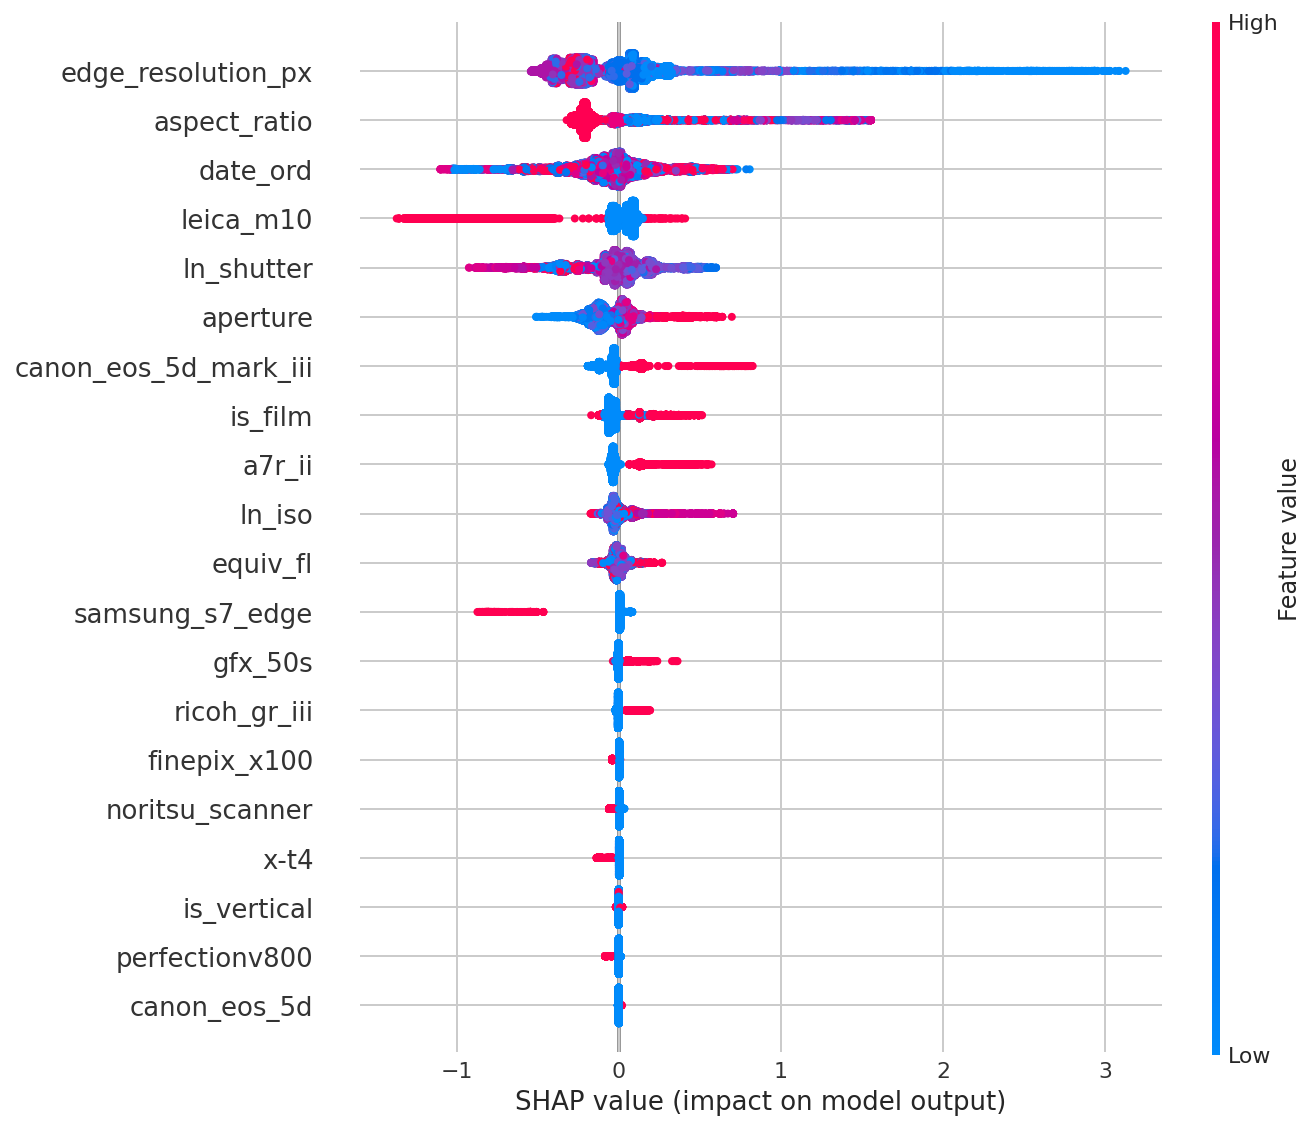

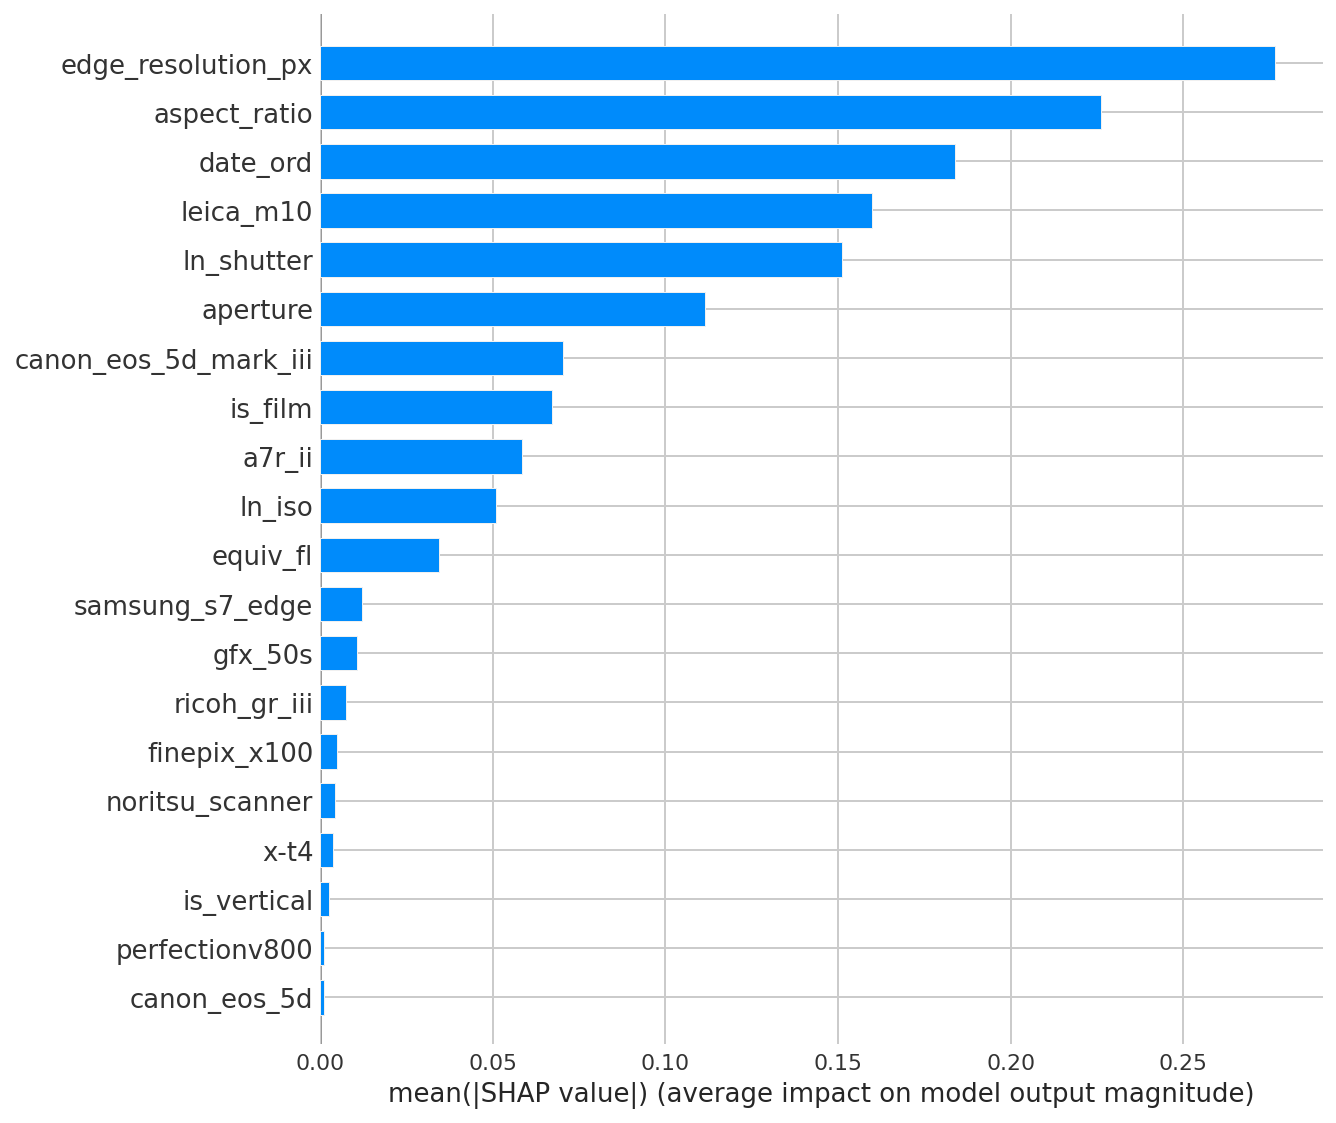

0it [00:00, ?it/s]



 * * Fit regularized linear model on timeseries CV: * *
AUCs by TS slice:  [0.5, 0.711, 0.573, 0.631, 0.547, 0.668, 0.532, 0.68, 0.564, 0.62]  avg:  0.603


 * Fit XGB on timeseries CV: * *
XGB AUCs by TS slice:  [0.6, 0.721, 0.591, 0.623, 0.713, 0.639, 0.63, 0.832, 0.574, 0.58]  avg:  0.65


In [203]:
# Try using flagged rather than rated 1+, since my flags are more stable over time
# (I used to rate photos less often)

OUTCOME = 'flag'

# -1 is "rejected"; consider it to be unflagged
ratings_md.loc[ratings_md.flag == -1, 'flag'] = 0

fit_basic_lr(
    RAW_X_COLS,
    OHE_X_COLS,
    OUTCOME,
)

#### Takeaways from frequentist LR on full metadata dataset __TODO__

Both outcomes generate pitful (but highly significant) R2.  


better results with:

- lower resolution (but the high resolution cameras score higher - GFX, a7r II - is this a scanning artifact?)
- some cameras (gfx, a7r II; again, above confound)
- more recent (time to pat myself on the back, back but it's a small effect)
- film (better, kinda)
- very small or non-signif effects of: focal length, iso, is-vertical, shutter speed

No effect of:
- focal length
- some cameras

__had some issues w/ solvers not converging.__ already normalized features (often req'd for good convergence.) L1 reg helps.

right now, don't trust camera-OHE effects

### Use this larger dataset (from metadata) to build expanded causal DAG

Needless to say, we will not capture all causal inputs. Thereforce this DAG is incomplete and imperfect!

We'll use our less sparse outcome - photo is flagged (`flag`)

#### Start w/ similar causal model to above before expanding

In [14]:
# Causal inference & DoWhy boilerplate
import category_encoders as ce
from graphviz import Source
import graphviz
from dowhy import CausalModel
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
import statsmodels.api as sm


# only log really bad events, otherwise dowhy gets really verbose
import logging
logger = logging.getLogger("dowhy").setLevel(logging.WARNING)
# also ignore that DoWhy feeds 1-column df for y instead of 1d array (series)
from sklearn.exceptions import DataConversionWarning
import warnings
warnings.filterwarnings(action='ignore', category=DataConversionWarning)



In [15]:
# DoWhy requires treatments to be encoded as ints, not str 
# (but multiclass treatments are fine for some methods, excl e.g. propensity scoring, stratfication)
import category_encoders as ce


ratings_md.camera = ratings_md.camera.str.replace(' ', '_')

CAMERAS_TO_ENC = [
    'canon_eos_5d_mark_iii',    
    'a7r_ii',                   
    'leica_m10',                
    'gfx_50s',                  
    'finepix_x100',             
    'canon_eos_5d',           
    'gfx_100',       
    'noritsu_scanner',
]
# exclude some less common models to simplify interpretation

ratings_md['top_camera'] = ratings_md.camera.copy()
ratings_md.loc[~(ratings_md.camera.isin(CAMERAS_TO_ENC)), 'top_camera'] = 'other'
fil_dslr_scan = (ratings_md.camera.isin(['a7r_ii', 'gfx_50s', 'gfx_100']) & (ratings_md.is_film == 1))
ratings_md.loc[fil_dslr_scan, 'top_camera'] = 'dslr_scan'

camera_encoder = ce.OrdinalEncoder()

# Obnoxiously, some EconML methods seem to require ordinal encoding for treatment be zero-indexed!
ratings_md['camera_discrete_enc'] = camera_encoder.fit_transform(ratings_md.top_camera) - 1  

ratings_md['top_camera'].value_counts(dropna=False)

treat_map = camera_encoder.mapping[0]['mapping'].to_dict()
treat_map
ratings_md['camera_discrete_enc'].value_counts(dropna=False)

canon_eos_5d_mark_iii    4920
a7r_ii                   3894
leica_m10                3376
gfx_50s                  2284
finepix_x100             2280
dslr_scan                2274
canon_eos_5d             2111
other                    1828
noritsu_scanner          1365
gfx_100                  1314
Name: top_camera, dtype: int64

{'canon_eos_5d': 1,
 'finepix_x100': 2,
 'canon_eos_5d_mark_iii': 3,
 'a7r_ii': 4,
 'other': 5,
 'leica_m10': 6,
 'dslr_scan': 7,
 'gfx_50s': 8,
 'noritsu_scanner': 9,
 'gfx_100': 10,
 nan: -2}

2    4920
3    3894
5    3376
7    2284
1    2280
6    2274
0    2111
4    1828
8    1365
9    1314
Name: camera_discrete_enc, dtype: int64

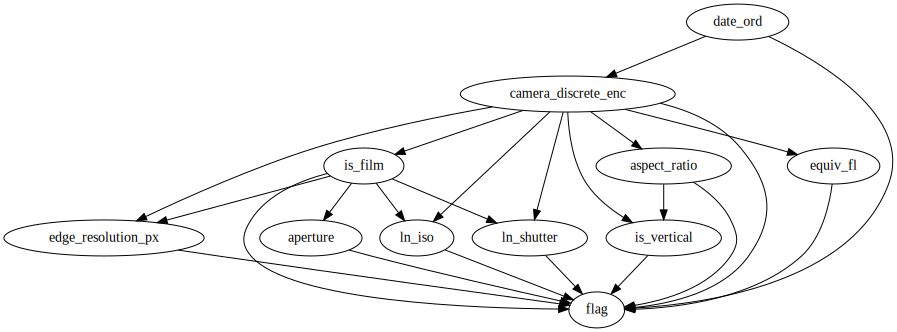

In [16]:
# Configure causal graph
import graphviz 


GRAPH = """digraph {
    camera_discrete_enc -> {equiv_fl, is_film, edge_resolution_px, aspect_ratio, is_vertical, flag, ln_iso, ln_shutter};
    equiv_fl -> flag;
    ln_iso -> flag;
    edge_resolution_px -> flag;
    date_ord -> camera_discrete_enc;
    date_ord -> flag;
    aspect_ratio -> flag;
    aspect_ratio -> is_vertical;
    is_film -> {flag, ln_shutter, aperture, ln_iso, edge_resolution_px};
    is_vertical -> flag;
    ln_shutter -> flag;
    aperture -> flag;
}""".replace('\n','')  # PyDot accepts with newlines but DoWhy sees as invalid - need to remove.

pydot_src = graphviz.Source(GRAPH)

from IPython.display import Image, display

pydot_src

In [186]:
# constants & prep data
from sklearn.linear_model import LassoCV, LogisticRegressionCV, BayesianRidge, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
import econml
from dowhy import CausalModel
from tqdm import tqdm


REFUTATION_STRATS = [
    ["random_common_cause", {'effect_strength_on_treatment': 0.1}],
    ["add_unobserved_common_cause", {'effect_strength_on_treatment': 0.1, 'effect_strength_on_outcome': 0.025}],
    #["placebo_treatment_refuter", {}],  # has been slooow
    #["data_subset_refuter", {'subset_fraction': 0.8}],        # same
]
OUTCOME = 'flag'

TREATMENT = 'camera_discrete_enc'

LIN_REG_PARAMS = {
    'num_null_simulations':50,
    'num_simulations':50,
    'num_quantiles_to_discretize_cont_cols':32,
    'fit_method': "statsmodels",
    'need_conditional_estimates': False,
}

LR_PARAMS = {
    'num_null_simulations':50,
    'num_simulations':50,
    'num_quantiles_to_discretize_cont_cols':32,
    'fit_method': "statsmodels",
    'glm_family': sm.families.Binomial(),  # logistic regression
    'need_conditional_estimates': False,
}

SHARED_XGB_PARAMS = {
    'max_depth': 5,
    'learning_rate': .1,
    'n_estimators': 100,
    'subsample': .8,
    #'colsample_by_tree': .8,
    'reg_alpha': 0.1,
    #'reg_lambda': 1.0,
    'tree_method': 'hist',
    'grow_policy': 'depthwise', 
    'n_jobs': -1,
    'use_label_encoder':False,
    
}

BASIC_XGB_REG = xgb.XGBRegressor(
    objective='reg:squarederror',
    eval_metric='mae',
    **SHARED_XGB_PARAMS
)

BASIC_XGB_BINARY = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    **SHARED_XGB_PARAMS
)

BASIC_XGB_MULTICLASS = xgb.XGBClassifier(
    objective="multi:mlogloss",
    eval_metric="mlogloss",
    **SHARED_XGB_PARAMS
)

ECONML_LIN_DML_PARAMS = {
    "init_params":{
        "model_y": BASIC_XGB_REG,#"auto", 
        "model_t": BASIC_XGB_MULTICLASS,#LogisticRegressionCV(Cs=[.1,1,10], cv=5, max_iter=1_000),
        "featurizer":PolynomialFeatures(degree=1, include_bias=True),
        "discrete_treatment": True,
        "linear_first_stages": False,
        'cv': 5,
        'random_state': 123,
    },
    "fit_params":{}
}

# Need to specify params for nuisance models in EconML
# The LinearDRLearner also requires two auxiliary models to model the relationships 
# $T\sim (W, X)$ (model_propensity) and $Y \sim (W, X)$(model_regression). 
# These can be generic, flexible classification and regression models, respectively.
# See: https://github.com/microsoft/EconML/blob/master/notebooks/CustomerScenarios/Case%20Study%20-%20Multi-investment%20Attribution%20at%20A%20Software%20Company%20-%20EconML%20%2B%20DoWhy.ipynb

ECONML_ALL_LIN_DR_PARAMS = { # see https://econml.azurewebsites.net/_autosummary/econml.dr.DRLearner.html
    "init_params":{
        'model_regression': econml.sklearn_extensions.linear_model.WeightedLassoCV(eps=0.001, alphas=[.1,1,10], n_jobs=-1, cv=3),  # 'auto' -> lasso
        'model_propensity': LogisticRegressionCV(Cs=[.1,1,10], max_iter=1_000, n_jobs=-1,cv=3),  # 'auto' -> lasso
        #'model_final': LogisticRegressionCV(),
        'random_state': 123,
        'cv': 5,
    },
    "fit_params":{},
    'need_conditional_estimates': False,
}

ECONML_LIN_DR_PARAMS = { # see https://econml.azurewebsites.net/_autosummary/econml.dr.DRLearner.html
    "init_params":{
        'model_regression': BASIC_XGB_REG, #'auto',
        'model_propensity': BASIC_XGB_MULTICLASS, #'auto',
        #'model_final': LogisticRegressionCV(),
        'random_state': 123,
        'cv': 5,
    },
    "fit_params":{},
    'need_conditional_estimates': False,
}

# btw, there's a handy dandy flowchart of EconML methods here:
# https://econml.azurewebsites.net/spec/flowchart.html
#
# and an experimental comparison with examples of necessary kwargs here:
# https://github.com/microsoft/dowhy/blob/master/docs/source/example_notebooks/dowhy_ranking_methods.ipynb

CAUSAL_METHODS = [
    ('backdoor.generalized_linear_model', LR_PARAMS),  # GLM, for logistic reg
    # Note: can't use IPW/IPS since we have a non-binary treatment.
    ('backdoor.econml.dml.LinearDML', ECONML_LIN_DML_PARAMS),  # double ML (final stage linear)
    ('backdoor.econml.dr.LinearDRLearner', ECONML_ALL_LIN_DR_PARAMS), # linear doubly-robust (all stages linear)
    ('backdoor.econml.dr.LinearDRLearner', ECONML_LIN_DR_PARAMS), # doubly-robust (final stage linear)
    #('backdoor.econml.dr.DRLearner', ECONML_DR_PARAMS),  # black box doubly robust estimator, but extra work for final estimator
]

ALL_CONFOUNDS = [
    'equiv_fl', 'is_film', 'edge_resolution_px', 'is_vertical', 'aspect_ratio', 'date_ord', 'ln_iso',
]

# This matrix style specification only necessary if you have "factorial" type design where 
# e.g. you can be affected by treatment 1 and 2 but not 3, 1 and 3 but not 2, etc.
# CONDITIONS = [
#     [(1,0,0,0),(0,1,1,1)],
#     [(0,1,0,0),(1,0,1,1)],
#     [(0,0,1,0),(1,1,0,1)],
#     [(0,0,0,1),(1,1,1,0)],
# ]

ratings_md_ = ratings_md.copy()
# Confirm treatment is never null.
ratings_md_ = ratings_md_.loc[ratings_md_[TREATMENT].notna()]
ratings_md_ = ratings_md_.loc[ratings_md_[OUTCOME].isin([0,1])]
ratings_md_ = ratings_md_.fillna(ratings_md_.mean())

# Make sure we're just using desired cols (not necessary but makes input data more readable)
all_cols_desired = [OUTCOME, TREATMENT] + ALL_CONFOUNDS
ratings_md_ = ratings_md_[all_cols_desired]

# normalize features / confounds (not necessary unless using linear models, but we are)
ratings_md_[ALL_CONFOUNDS] = (
   (ratings_md_[ALL_CONFOUNDS] - ratings_md_[ALL_CONFOUNDS].mean()) / ratings_md_[ALL_CONFOUNDS].std()
)

ratings_md_.sample(10,random_state=42)

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.


,flag,camera_discrete_enc,equiv_fl,is_film,edge_resolution_px,is_vertical,aspect_ratio,date_ord,ln_iso
12840,0,3,9.739988e-01,-0.416414,0.564492,-0.523624,0.527087,0.054240,-0.969582
1518,0,0,1.734510e+00,-0.416414,-1.155067,-0.523624,0.529180,-1.810531,-0.969582
8504,0,2,2.748524e+00,-0.416414,-0.487575,-0.523624,0.529180,-0.611119,-0.250113
7475,0,2,1.734510e+00,-0.416414,-0.487575,-0.523624,0.529180,-0.914486,1.188827
25901,0,9,1.886612e+00,-0.416414,2.674654,1.909693,-1.552363,1.425444,-0.969582
3003,0,1,-8.258767e-01,-0.416414,-1.197268,-0.523624,0.544772,-1.597969,0.469357
4058,0,2,1.734510e+00,-0.416414,-0.487575,-0.523624,0.529180,-1.415941,1.188827
11419,0,3,-8.005263e-01,-0.416414,0.564492,-0.523624,0.527087,-0.099104,-0.969582
2023,0,0,1.734510e+00,-0.416414,-1.155067,-0.523624,0.529180,-1.777422,-0.250113
25122,1,6,5.111951e-13,2.401362,2.674654,-0.523624,0.066615,1.346270,1.188827


In [187]:
# Do inference: does camera affect a photo's "goodness" (likelihood of being flagged as good)


def do_inference(
    data,
    treatment_col,
    outcome_col,
    graph,
    causal_methods,
    treat_map,
    refutation_strats
    ):
    """
    Try different causal inference strategies.
    """
    
    cates = []

    # I. 
    model = CausalModel(
        data=data,
        treatment=treatment_col,
        outcome=outcome_col,
        # use a graph, rather than basic common causes (cause both selection & outcome directly)
        graph=graph,
    )

    # II. Identify causal effect and return target estimands
    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)  # observational data

    n_conditions = ratings_md_[treatment_col].nunique()
    
    # Skip our control condition.
    treat_map = {c: c_no for c, c_no in treat_map.items() if c_no > 1}

    for causal_method, causal_method_params in tqdm(causal_methods):
        for condition, cond_no in tqdm(treat_map.items()):  # seems we have to test each condition separately?
            # Again, hack since EconML expects 0-indexed treatment idxs and CE outputs 1-idxed, have to manually -1.
            cond_no = cond_no - 1 
                
            # III. Estimate the target estimand using a statistical method.
            #print('')
            #print(condition, ' condition #:', cond_no)
            estimate = model.estimate_effect(
                identified_estimand,
                method_name=causal_method,
                #test_significance=False,
                #confidence_intervals=False,
                method_params=causal_method_params,
                control_value=0,
                treatment_value=cond_no,
            )
            #print(estimate)
            cate = {
                'causal_avg_treatment_effect': estimate.value,
                'treatment': condition,
                'causal_inference_method': causal_method,
                #'causal_inference_params': causal_method_params,
                'refuter': None,
                'refuter_params': None,
                **causal_method_params
            }
            cates.append(cate)        

            # IV. Refute the obtained estimate using multiple robustness checks.
            for refuter, args in refutation_strats:
                refute_results = model.refute_estimate(
                    identified_estimand, 
                    estimate,                
                    method_name=refuter,
                    treatment_value=cond_no,
                    #num_simulations=100,
                    random_seed=1234,
                    silent=True,
                    **args,
                )
                refuter_cate = refute_results.new_effect.ravel()[0]
                cate = {
                    'causal_avg_treatment_effect': refuter_cate,
                    'treatment': condition,
                    'causal_inference_method': causal_method,
                    #'causal_inference_params': causal_method_params,
                    'refuter': refuter,
                    'refuter_params': args,
                    **causal_method_params
                }
                cates.append(cate)

    cates_df = pd.DataFrame(cates)
    cates_df.causal_avg_treatment_effect = cates_df.causal_avg_treatment_effect.round(3)
    return cates_df

In [188]:
camera_cates_df = do_inference(
    ratings_md_,
    TREATMENT,
    OUTCOME,
    GRAPH,
    CAUSAL_METHODS,
    treat_map,
    REFUTATION_STRATS,
)

ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...
100%|██████████| 4/4 [16:28<00:00, 247.16s/it]


,causal_avg_treatment_effect,treatment,causal_inference_method,refuter,refuter_params,num_null_simulations,num_simulations,num_quantiles_to_discretize_cont_cols,fit_method,glm_family,need_conditional_estimates,causal_inference_params,init_params,fit_params,_econml_methodname
0,0.000,canon_eos_5d,backdoor.generalized_linear_model,None,None,50.0,50.0,32.0,statsmodels,<statsmodels.genmod.families.family.Binomial o...,False,NaN,NaN,NaN,NaN
1,0.000,canon_eos_5d,backdoor.generalized_linear_model,random_common_cause,{'effect_strength_on_treatment': 0.1},NaN,NaN,NaN,NaN,NaN,NaN,"{'num_null_simulations': 50, 'num_simulations'...",NaN,NaN,NaN
2,0.000,canon_eos_5d,backdoor.generalized_linear_model,add_unobserved_common_cause,"{'effect_strength_on_treatment': 0.1, 'effect_...",NaN,NaN,NaN,NaN,NaN,NaN,"{'num_null_simulations': 50, 'num_simulations'...",NaN,NaN,NaN
3,0.007,finepix_x100,backdoor.generalized_linear_model,None,None,50.0,50.0,32.0,statsmodels,<statsmodels.genmod.families.family.Binomial o...,False,NaN,NaN,NaN,NaN
4,0.007,finepix_x100,backdoor.generalized_linear_model,random_common_cause,{'effect_strength_on_treatment': 0.1},NaN,NaN,NaN,NaN,NaN,NaN,"{'num_null_simulations': 50, 'num_simulations'...",NaN,NaN,NaN
5,0.003,finepix_x100,backdoor.generalized_linear_model,add_unobserved_common_cause,"{'effect_strength_on_treatment': 0.1, 'effect_...",NaN,NaN,NaN,NaN,NaN,NaN,"{'num_null_simulations': 50, 'num_simulations'...",NaN,NaN,NaN
6,0.014,canon_eos_5d_mark_iii,backdoor.generalized_linear_model,None,None,50.0,50.0,32.0,statsmodels,<statsmodels.genmod.families.family.Binomial o...,False,NaN,NaN,NaN,NaN
7,0.014,canon_eos_5d_mark_iii,backdoor.generalized_linear_model,random_common_cause,{'effect_strength_on_treatment': 0.1},NaN,NaN,NaN,NaN,NaN,NaN,"{'num_null_simulations': 50, 'num_simulations'...",NaN,NaN,NaN
8,0.006,canon_eos_5d_mark_iii,backdoor.generalized_linear_model,add_unobserved_common_cause,"{'effect_strength_on_treatment': 0.1, 'effect_...",NaN,NaN,NaN,NaN,NaN,NaN,"{'num_null_simulations': 50, 'num_simulations'...",NaN,NaN,NaN
9,0.022,a7r_ii,backdoor.generalized_linear_model,None,None,50.0,50.0,32.0,statsmodels,<statsmodels.genmod.families.family.Binomial o...,False,NaN,NaN,NaN,NaN


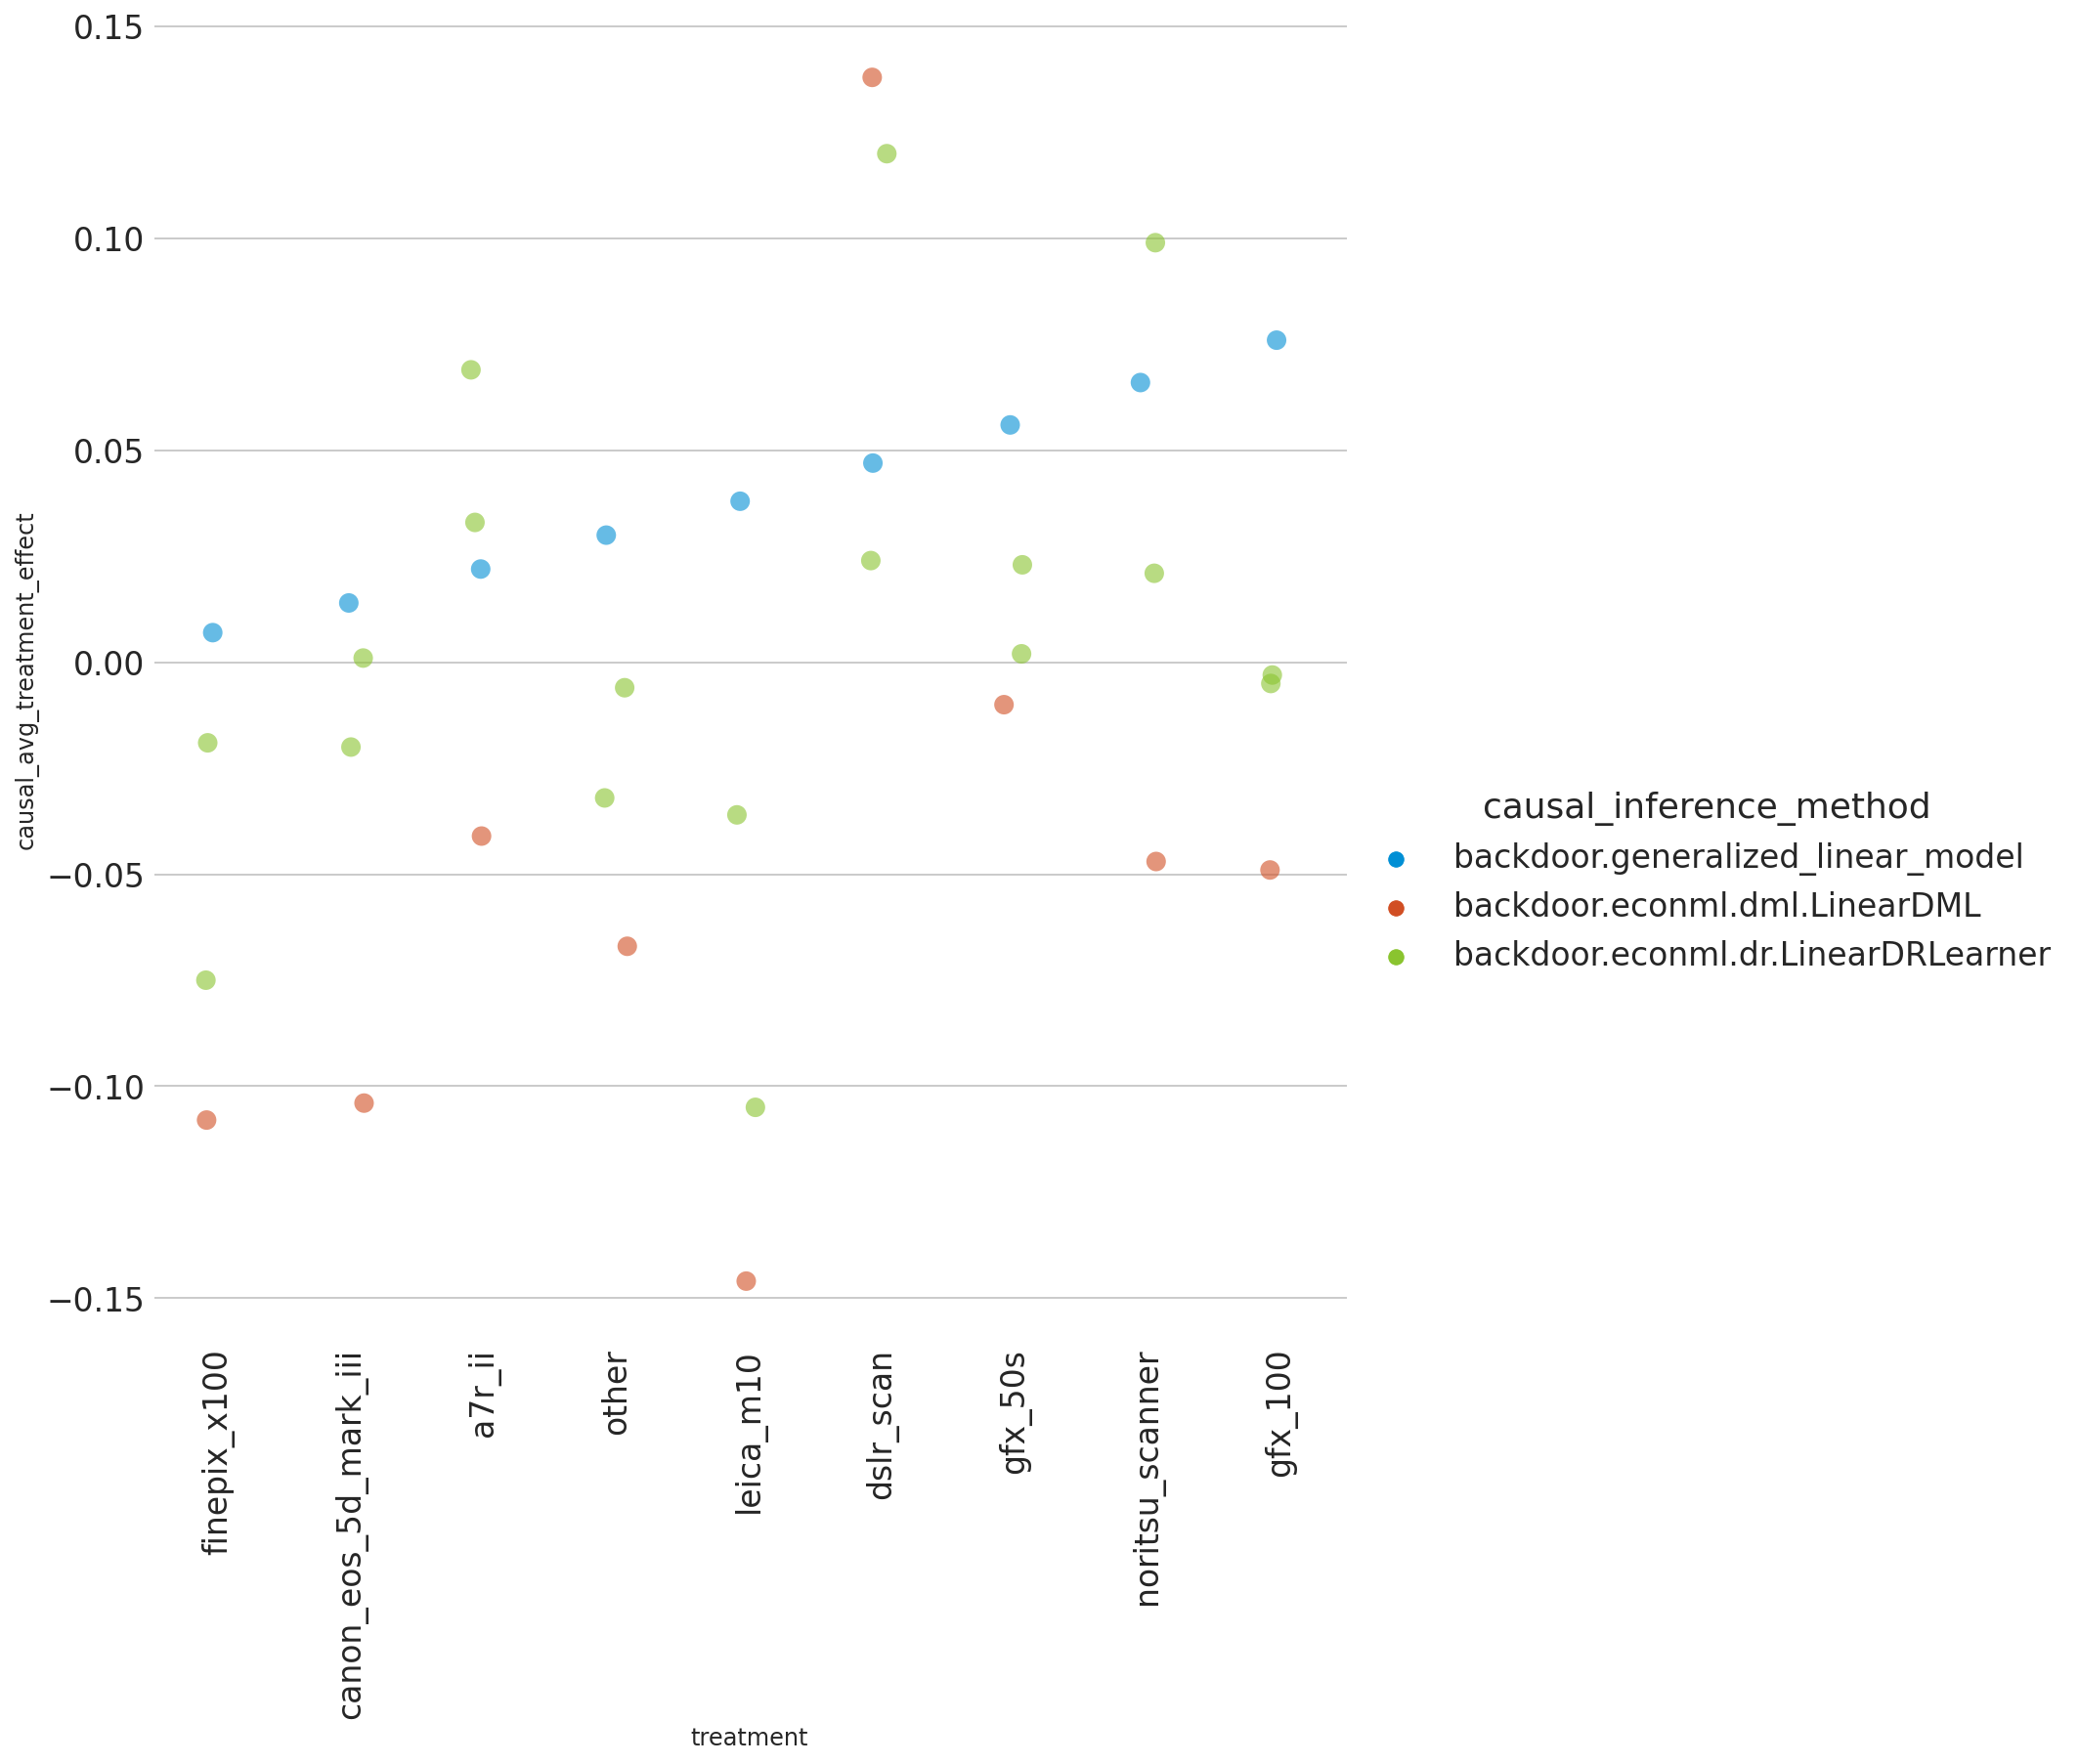

In [189]:
sns.catplot(
    x='treatment',
    y='causal_avg_treatment_effect',
    hue='causal_inference_method',
    data=camera_cates_df.loc[camera_cates_df.refuter.fillna('no_refuter') == 'no_refuter'],
    height=10,
    s=10,
    alpha=.6,
    kind='strip',
    #join=False,
    #scatter_kws={'alpha':.5}
)
_ = plt.xticks(rotation=90)
cates_df.head(10)

In [76]:
# compare with univariate logistic regression 
import statsmodels.formula.api as smf


xys = ratings_md_.copy()
xys['top_camera'] = camera_encoder.inverse_transform(xys.camera_discrete_enc.rename('top_camera')).fillna('other')
xys['constant'] = 1
fitted = smf.logit('flag ~ top_camera', data=xys).fit()
fitted.summary()
#ratings_md_

Optimization terminated successfully.
         Current function value: 0.419806
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   flag   No. Observations:                25531
Model:                          Logit   Df Residuals:                    25522
Method:                           MLE   Df Model:                            8
Date:                Sun, 08 Aug 2021   Pseudo R-squ.:                 0.02082
Time:                        21:32:17   Log-Likelihood:                -10718.
converged:                       True   LL-Null:                       -10946.
Covariance Type:            nonrobust   LLR p-value:                 2.126e-93
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -1.9585      0.071    -27.562      0.000      -2.098      -1.819
top_camera[T.canon_eos_5d]              0.2239      0.092      2.430      0.015       0.043       0.404
top_camera[T.canon_eos_5d_mark_iii]     0.1887      0.084      2.237      0.025       0.023       0.354
top_camera[T.dslr_scan]                 0.2336      0.092      2.540      0.011       0.053       0.414
top_camera[T.finepix_x100]              0.2876      0.081      3.546      0.000       0.129       0.447
top_camera[T.gfx_50s]                   0.3778      0.101      3.736      0.000       0.180       0.576
top_camera[T.leica_m10]                 1.1240      0.085     13.291      0.000       0.958       1.290
top_camera[T.noritsu_scanner]           0.1897      0.106      1.794      0.073      -0.018       0.397
top_camera[T.other]                    -0.2078      0.084     -2.474      0.013      -0.372      -0.043
=======================================================================================================
"""

In [77]:
# compare w/ old school naive logistic regression

fitted = smf.logit('flag ~ top_camera + equiv_fl + is_film + edge_resolution_px + is_vertical + aspect_ratio + date_ord + ln_iso', data=xys).fit()
fitted.summary()

Optimization terminated successfully.
         Current function value: 0.413296
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   flag   No. Observations:                25531
Model:                          Logit   Df Residuals:                    25515
Method:                           MLE   Df Model:                           15
Date:                Sun, 08 Aug 2021   Pseudo R-squ.:                 0.03600
Time:                        21:35:06   Log-Likelihood:                -10552.
converged:                       True   LL-Null:                       -10946.
Covariance Type:            nonrobust   LLR p-value:                2.878e-158
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -2.3364      0.091    -25.642      0.000      -2.515      -2.158
top_camera[T.canon_eos_5d]             -0.1366      0.124     -1.099      0.272      -0.380       0.107
top_camera[T.canon_eos_5d_mark_iii]     1.1469      0.129      8.913      0.000       0.895       1.399
top_camera[T.dslr_scan]                 1.3859      0.142      9.742      0.000       1.107       1.665
top_camera[T.finepix_x100]              0.5344      0.116      4.617      0.000       0.308       0.761
top_camera[T.gfx_50s]                  -0.2872      0.232     -1.236      0.217      -0.743       0.168
top_camera[T.leica_m10]                 0.9819      0.223      4.402      0.000       0.545       1.419
top_camera[T.noritsu_scanner]           2.6330      0.218     12.087      0.000       2.206       3.060
top_camera[T.other]                    -0.1881      0.103     -1.818      0.069      -0.391       0.015
equiv_fl                               -0.0304      0.025     -1.218      0.223      -0.079       0.019
is_film                                 0.4502      0.088      5.143      0.000       0.279       0.622
edge_resolution_px                     -0.7431      0.058    -12.777      0.000      -0.857      -0.629
is_vertical                            -0.1083      0.044     -2.434      0.015      -0.195      -0.021
aspect_ratio                           -0.2616      0.047     -5.510      0.000      -0.355      -0.169
date_ord                               -0.0003      0.036     -0.007      0.994      -0.070       0.070
ln_iso                                 -0.0173      0.022     -0.801      0.423      -0.060       0.025
=======================================================================================================
"""

### Results:

_caveat: ATE units ?= logodds (LR units)_

effects seem _different_, but not terribly consistent.
my guess is that they're just too small/nonexistent to pick up on, but you'd be naive to trust the simple LR.  

perhaps worth mentioning that my home-scanned (DSLR-scanned) negatives seem to do well across the board.  


#### Try finding causal effect of is_film

not sure how well-specified this is. that is, is_film is driven by camera, which I'm controlling for?  
so do I need to remove the camera variable?  

In [183]:
TREATMENT_2 = 'is_film'

# binary treatment so replace model_t
ECONML_DML_PARAMS = {
    "init_params": {
        "model_y": BASIC_XGB_REG,  # I think this should be clf as well (binary outcome), but errors
        "model_t": BASIC_XGB_BINARY,
        "cv": 5,
        "discrete_treatment": True,
        "linear_first_stages": False,
        'random_state': 123,
    },  # outcome is binary, treatment is multiclass
    "fit_params": {"inference": "auto"},
}

ECONML_DR_PARAMS = {
    "init_params":{
        'model_regression': BASIC_XGB_REG,  # I think this should be clf as well (binary outcome), but errors
        'model_propensity': BASIC_XGB_BINARY,  #'auto',
        'categories': 'auto',
        'random_state': 123,
        "cv": 5,
    },
    "fit_params":{},
    'need_conditional_estimates': False,
}

CAUSAL_METHODS_2 = [
    ('backdoor.generalized_linear_model', LR_PARAMS),  # GLM, for logistic reg
    # Binary treatment, so we can use propensity-based methods.
    ('backdoor.propensity_score_weighting', {'need_conditional_estimates': False}),  # control for selection bias with basic inverse propensity score
    ('backdoor.propensity_score_stratification', {'need_conditional_estimates': False}),  # similar to IPS but with reduced variance issues
    #('backdoor.propensity_score_matching', {'need_conditional_estimates': False}),  # 
    ('backdoor.econml.dml.LinearDML', ECONML_DML_PARAMS),  
    ('backdoor.econml.dr.LinearDRLearner', ECONML_DR_PARAMS),
    ('backdoor.econml.dr.LinearDRLearner', ECONML_ALL_LIN_DR_PARAMS),   
]

TREAT_MAP_FILM = {  # expects 1-indexed
    'digital': 1,
    'film': 2,
}

In [184]:
is_film_cates_df = do_inference(
    ratings_md_.assign(is_film = lambda df: (df.is_film > 0).astype('bool')),  # propensity wants bool, so we give it bool :)
    TREATMENT_2,
    OUTCOME,
    GRAPH,
    CAUSAL_METHODS_2,
    TREAT_MAP_FILM,
    REFUTATION_STRATS,
)

ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...
100%|██████████| 6/6 [00:18<00:00,  3.11s/it]


Reference: discussion of double robustness, pluses and minuses (it's not a free lunch, doubly-robust can be worse than propensity-based models when both models are mis-specified!) https://arxiv.org/pdf/0804.2958.pdf


,causal_avg_treatment_effect,treatment,causal_inference_method,refuter,refuter_params,num_null_simulations,num_simulations,num_quantiles_to_discretize_cont_cols,fit_method,glm_family,need_conditional_estimates,init_params,fit_params,_econml_methodname
0,0.169,film,backdoor.generalized_linear_model,None,None,50.0,50.0,32.0,statsmodels,<statsmodels.genmod.families.family.Binomial o...,False,NaN,NaN,NaN
1,0.168,film,backdoor.generalized_linear_model,random_common_cause,{'effect_strength_on_treatment': 0.1},50.0,50.0,32.0,statsmodels,<statsmodels.genmod.families.family.Binomial o...,False,NaN,NaN,NaN
2,0.068,film,backdoor.generalized_linear_model,add_unobserved_common_cause,"{'effect_strength_on_treatment': 0.1, 'effect_...",50.0,50.0,32.0,statsmodels,<statsmodels.genmod.families.family.Binomial o...,False,NaN,NaN,NaN
3,0.055,film,backdoor.propensity_score_weighting,None,None,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN
4,0.055,film,backdoor.propensity_score_weighting,random_common_cause,{'effect_strength_on_treatment': 0.1},NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN
5,0.054,film,backdoor.propensity_score_weighting,add_unobserved_common_cause,"{'effect_strength_on_treatment': 0.1, 'effect_...",NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN
6,0.149,film,backdoor.propensity_score_stratification,None,None,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN
7,0.146,film,backdoor.propensity_score_stratification,random_common_cause,{'effect_strength_on_treatment': 0.1},NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN
8,0.027,film,backdoor.propensity_score_stratification,add_unobserved_common_cause,"{'effect_strength_on_treatment': 0.1, 'effect_...",NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN
9,0.449,film,backdoor.econml.dml.LinearDML,None,None,NaN,NaN,NaN,NaN,NaN,NaN,"{'model_y': XGBRegressor(base_score=None, boos...",{'inference': 'auto'},econml.dml.LinearDML


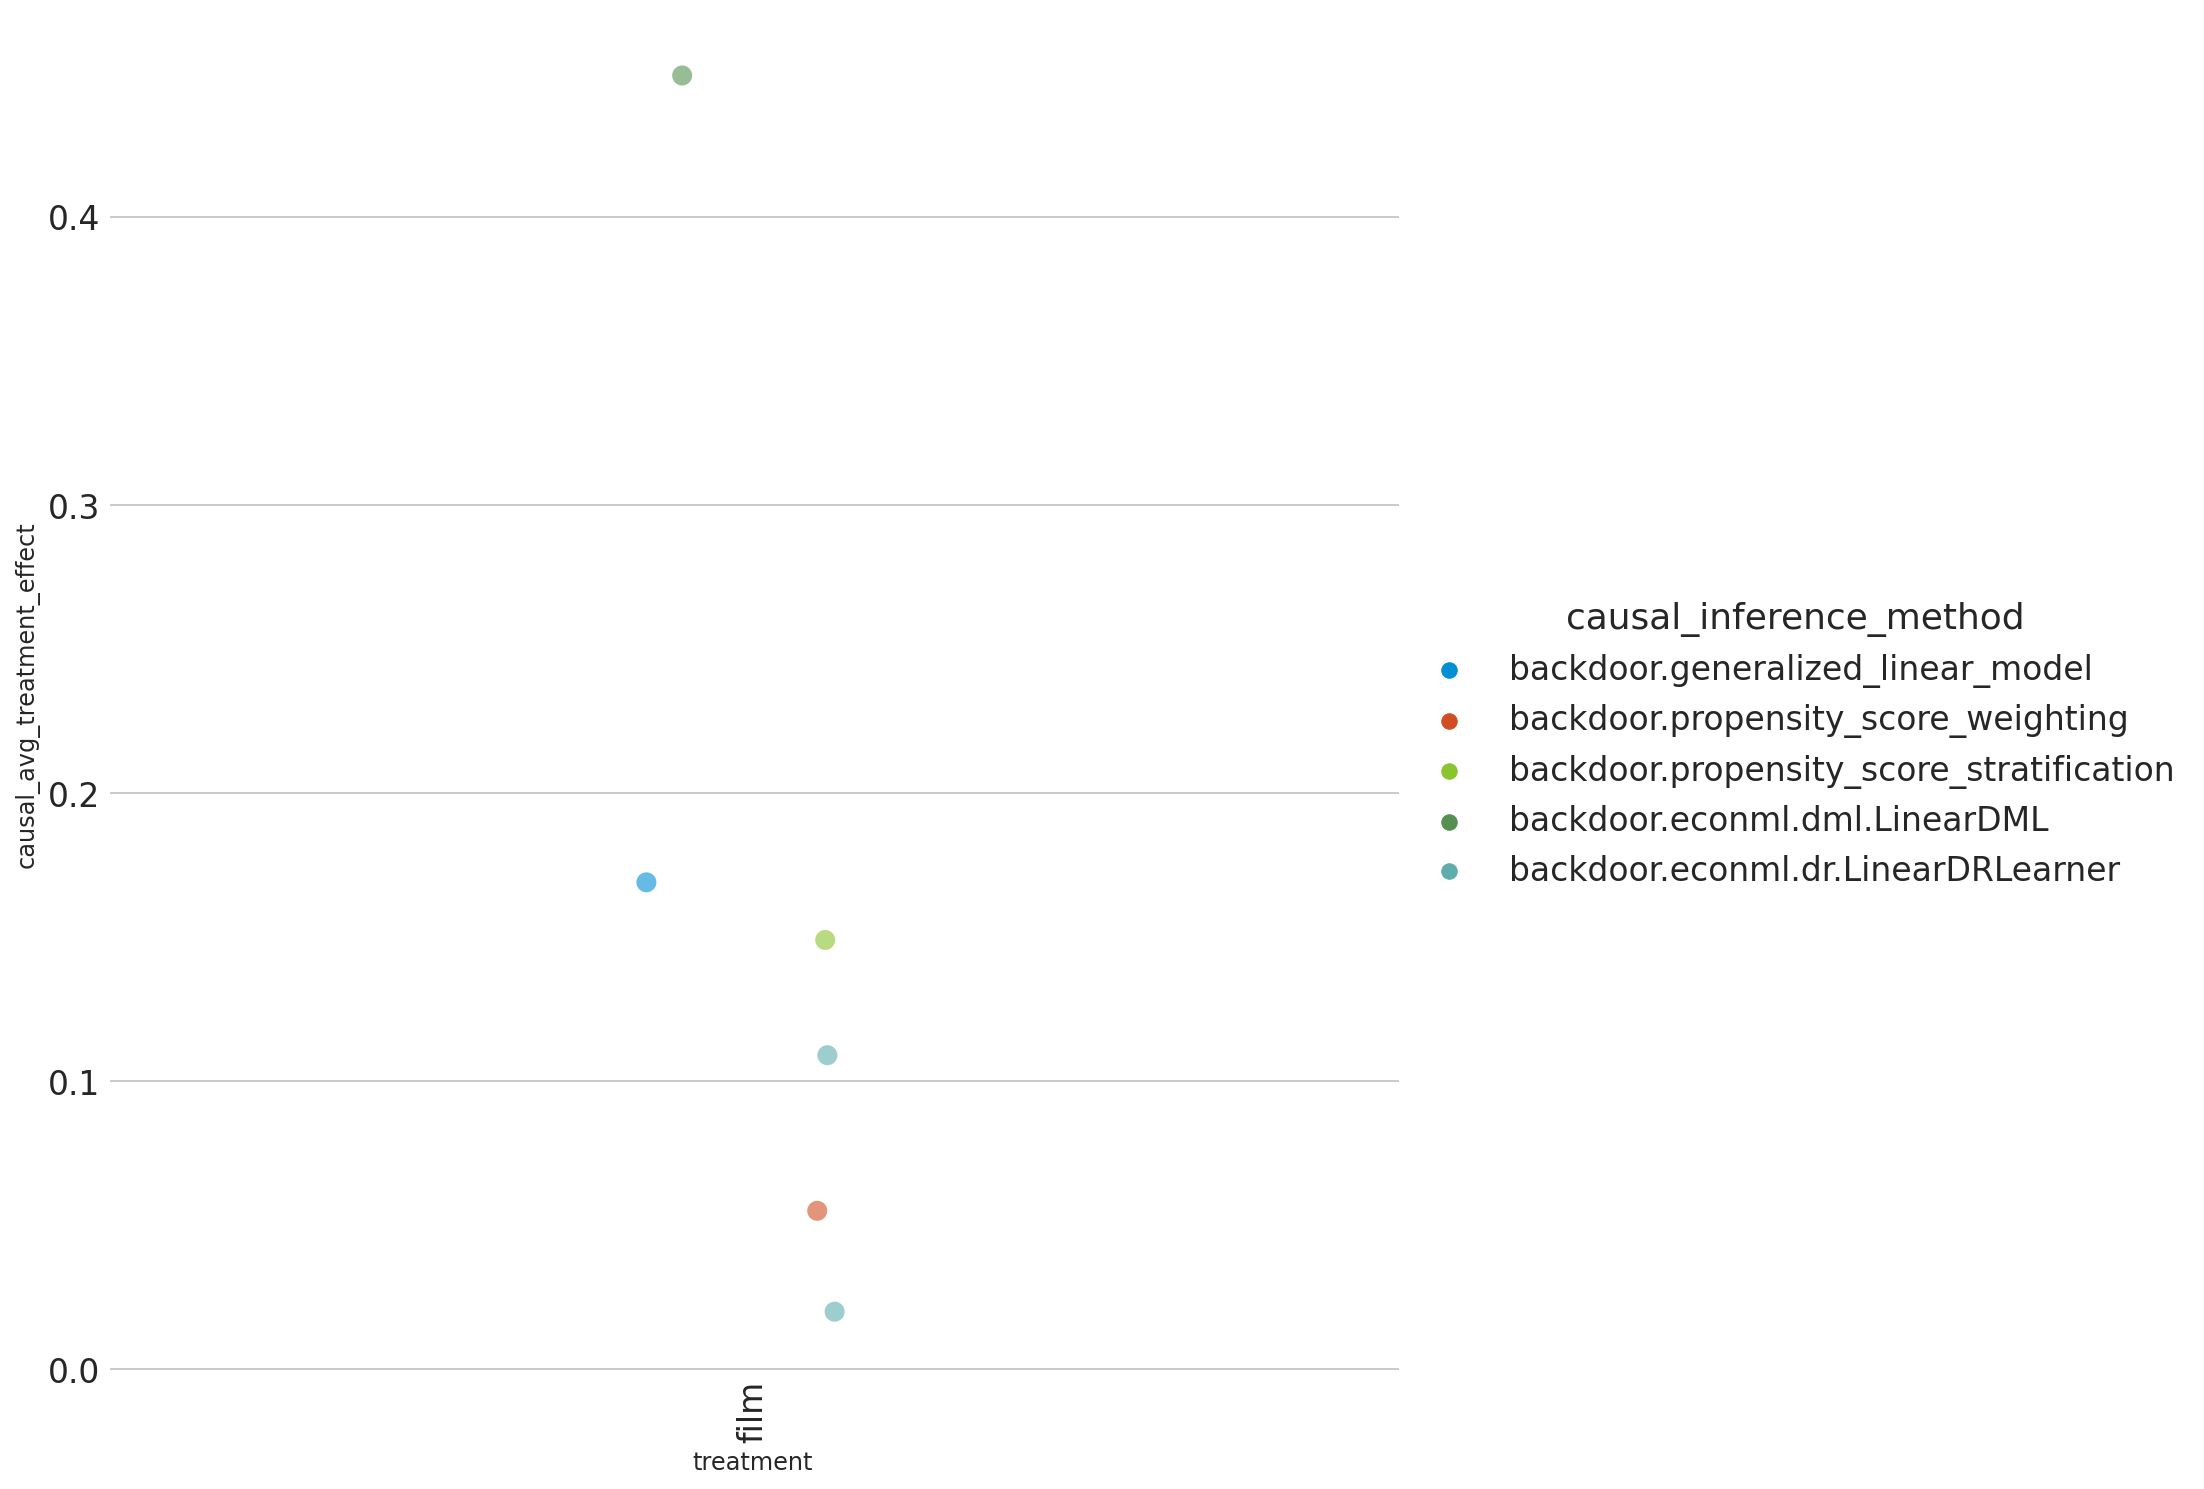

In [185]:
sns.catplot(
    x='treatment',
    y='causal_avg_treatment_effect',
    hue='causal_inference_method',
    data=is_film_cates_df.loc[is_film_cates_df.refuter.fillna('no_refuter') == 'no_refuter'],
    height=10,
    s=10,
    alpha=.6,
    kind='strip',
    #join=False,
    #scatter_kws={'alpha':.5}
)
_ = plt.xticks(rotation=90)
is_film_cates_df.head(10)

caveats:
- no confidence intervals (would require miserably slow bootstrapping)  
- think our "regression" model should be clf / bernoulli, not regression / gaussian  
- don't claim full mastery of DoWhy & EconML  
- last but not least, EconML integration into DoWhy is (semi-) experimental, plenty of API kinks remain

that said, __all of our methods show a positive effect for `is_film`, which is at least directionally suggestive__.  

(did you think we would get a real answer?! of course not!)